In [5]:
import warnings

warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")


import os
from pathlib import Path

import matplotlib.pyplot as plt
import MDAnalysis as mda
import numpy as np
import pandas as pd
from MDAnalysis.analysis import msd, rms
from mycolorpy import colorlist as mcp
from rdkit import Chem
from rdkit.Chem import Draw
from scipy.stats import linregress
import base
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('font', size=10)
plt.rc('axes', titlesize=16)
plt.rc('axes', labelsize=15)
plt.rc('legend', fontsize=10)
plt.rcParams["figure.figsize"] = (10, 7)

In [ ]:
%matplotlib inline

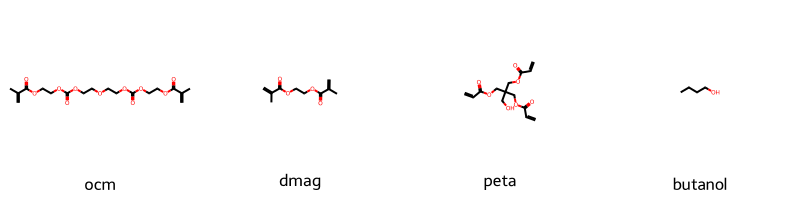

In [6]:
Draw.MolsToGridImage(
    list(base.RD_MOLECULES.values()),
    useSVG=True,
    molsPerRow=4,
    legends=[i.name for i in base.RD_MOLECULES.keys()],
)

In [50]:
# D cm2/day
def get_SysT_dir(work_dir1: str):
    result_dir = Path(work_dir1.replace('\\', '/'))
    for system_sir in os.listdir(result_dir.as_posix()):
        for T_dir in os.listdir((result_dir / system_sir).as_posix()):
            if (result_dir / system_sir / T_dir / 'msd.csv').exists():
                yield result_dir / system_sir / T_dir


def filter_df(df: pd.DataFrame, substance: base.MolNames) -> pd.DataFrame:
    but_time = df[df['BUT'] == df['BUT'].max()]['Time'].max()
    comp_time = df[df[substance.value] == df[substance.value].max()]['Time'].max()

    time_max = min(but_time, comp_time)
    # FIXME:
    time_min = 100 * 1e-12
    time_max = 1e-4
    # time_max = 100*1e-12
    return df[(time_min <= df['Time']) & (df['Time'] <= time_max)]


def regress(data):
    time, MSD = data['Time'], data.iloc[:, 1]
    regression = linregress(time, MSD)
    D0 = regression.intercept
    D = regression.slope
    return D, D0


def from_MSD(MSD_path, compound):
    residue = base.MolNames[compound].value
    MSD_data = pd.read_csv(MSD_path, index_col=0)
    time = MSD_data['Time']  # s
    MSD = MSD_data[residue]  # cm2
    return MSD_data


def from_mda(u, compound):
    residue = base.MolNames[compound].value
    selection = f'resname {residue}'
    m = msd.EinsteinMSD(u, select=selection)
    m.run()

    time = m.times * 1e-12  # ps -> s
    MSD = np.mean(m.results['msds_by_particle'], axis=1) * 1e-16  # A -> cm2
    return pd.DataFrame({'Time': time, residue: MSD}).fillna(0)


def get_RMSD(u, compound):
    residue = base.MolNames[compound].value
    selection = f'resname {residue}'
    m = rms.RMSD(u, u, selection)
    m.run()
    return pd.DataFrame(m.results.rmsd[:,1:], columns=['Time', residue])

def strict(df:pd.DataFrame):
    return df.loc[150:]

In [60]:
directory = Path('tests/4MD')
compound = 'ocm'
T = 25
pdb = directory / 'md.gro'
# pdb = 'tests/3NPT/npt.gro'
# traj = directory / 'md.xtc'
traj = directory / 'md2.xtc'

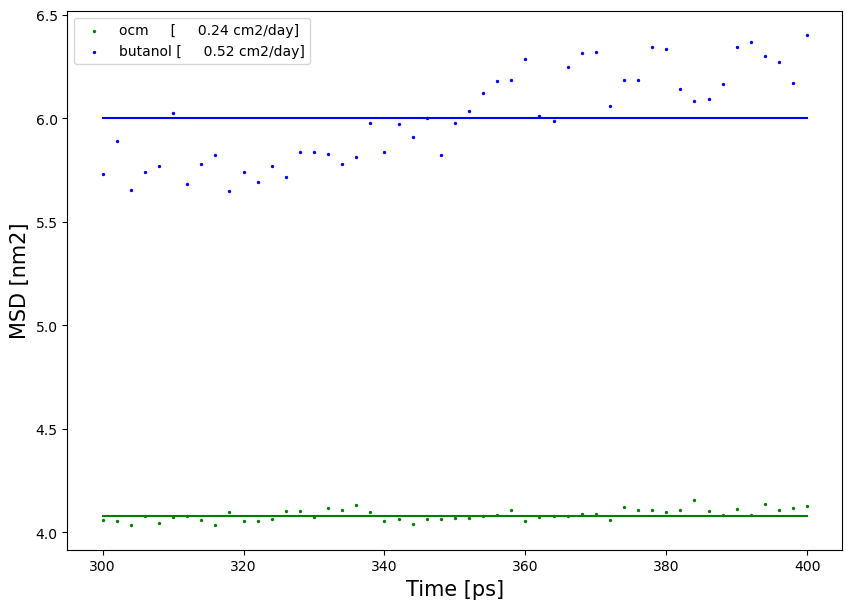

In [61]:
u = mda.Universe(pdb, traj)

# df = from_mda(u, compound)
# S, S0 = regress(df)
# D = S / 6 * 24 * 60 * 60

df = strict(get_RMSD(u, compound))
S, S0 = 0, df.iloc[:, 1].median()
D = S0**2 * 1e12 / 1e18 / 6 * 24 * 60 * 60


# df_but = from_mda(u, 'butanol')
# S_but, S0_but = regress(df_but)
# D_but = S_but / 6 * 24 * 60 * 60

df_but = strict(get_RMSD(u, 'butanol'))
S_but, S0_but = 0, df_but.iloc[:, 1].median()
D_but = S0_but**2 * 1e12 / 1e18 / 6 * 24 * 60 * 60

fig, ax = plt.subplots()
ax.set_ylabel('MSD [nm2]')
ax.set_xlabel('Time [ps]')

time = df['Time']
time_but = df_but['Time']
ax.scatter(
    time * x_scaller,
    df.iloc[:, 1] * y_scaller,
    label=f'{compound:7} [{D: 9.2f} cm2/day]',
    c='g',
    s=2,
)
ax.plot(time * x_scaller, (S * time + S0) * y_scaller, 'g')
ax.scatter(
    time_but * x_scaller,
    df_but.iloc[:, 1] * y_scaller,
    label=f'butanol [{D_but: 9.2f} cm2/day]',
    c='b',
    s=2,
)
ax.plot(time_but * x_scaller, (S_but * time_but + S0_but) * y_scaller, 'b-')
ax.legend()

# ax.set_title(f"{compound} - {x} butanol :{T} C")
# fig.savefig(f"MSD_old.jpg", dpi=600)

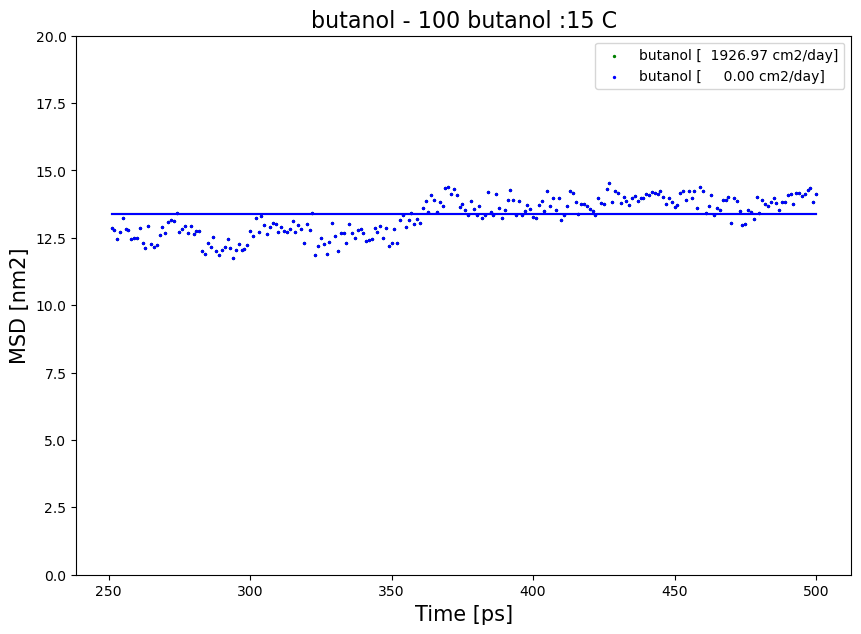

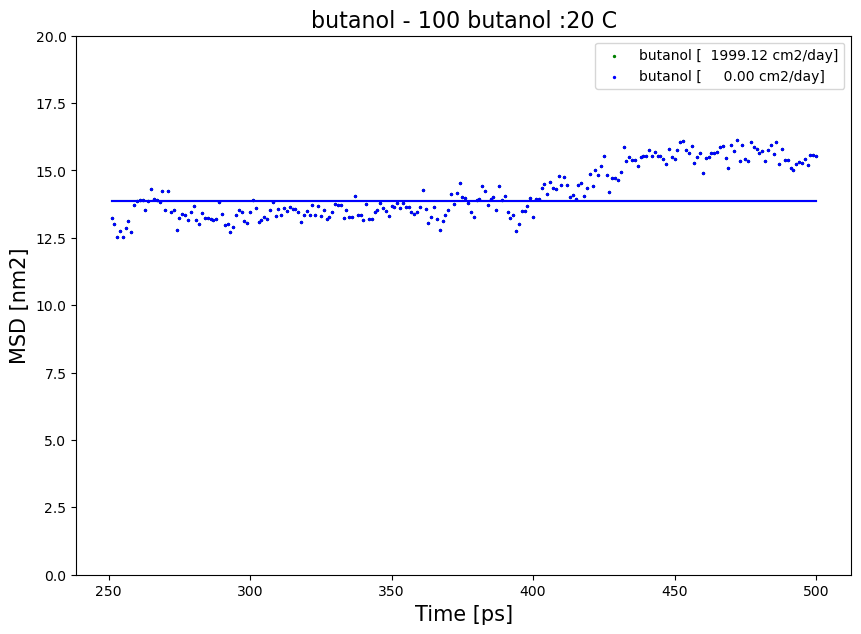

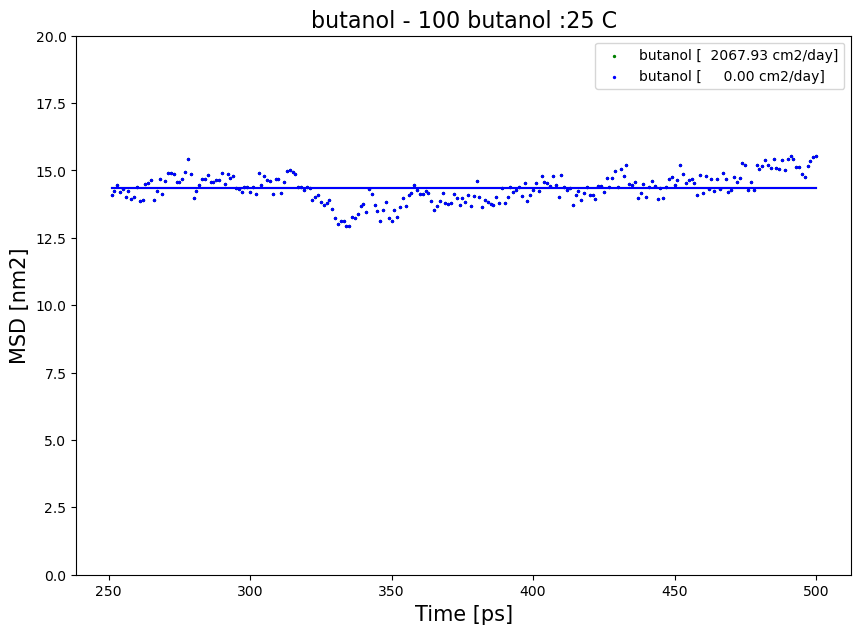

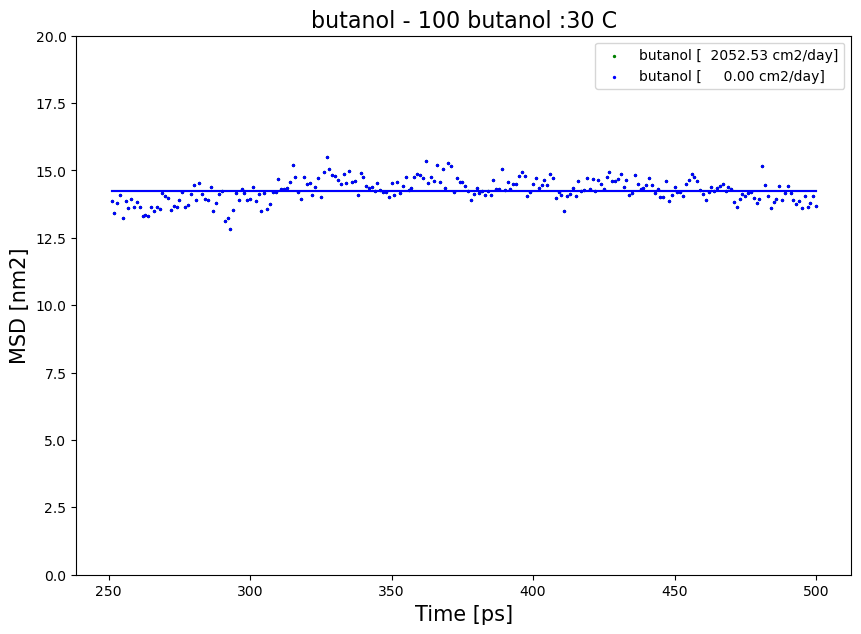

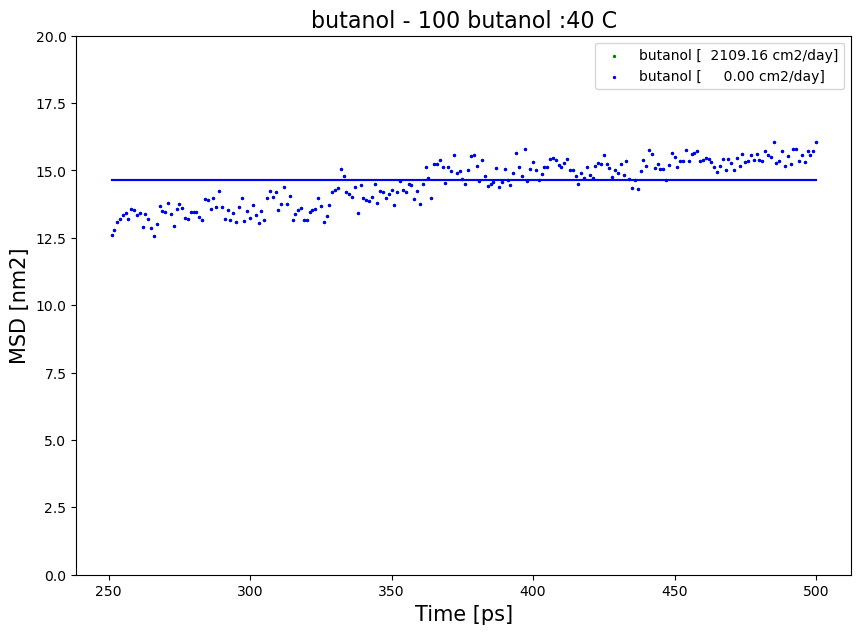

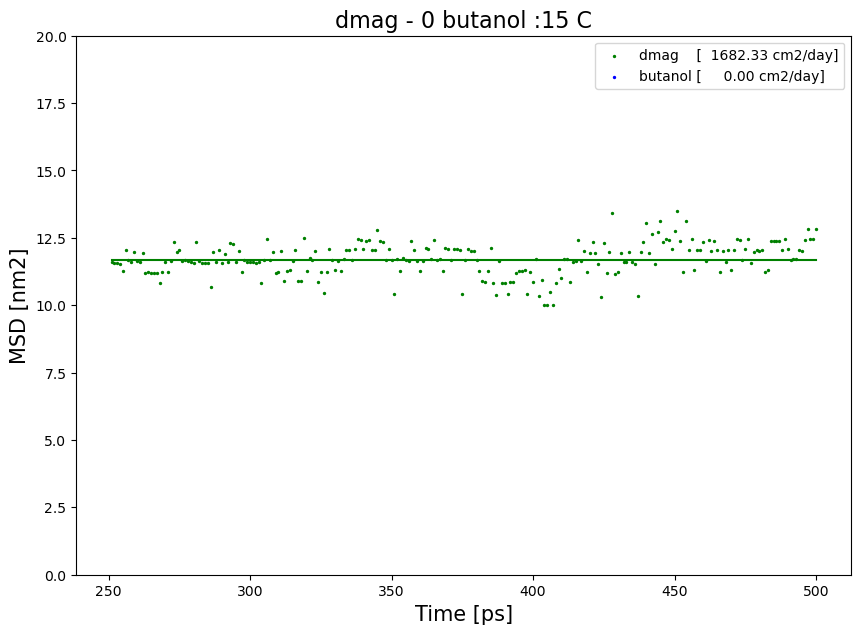

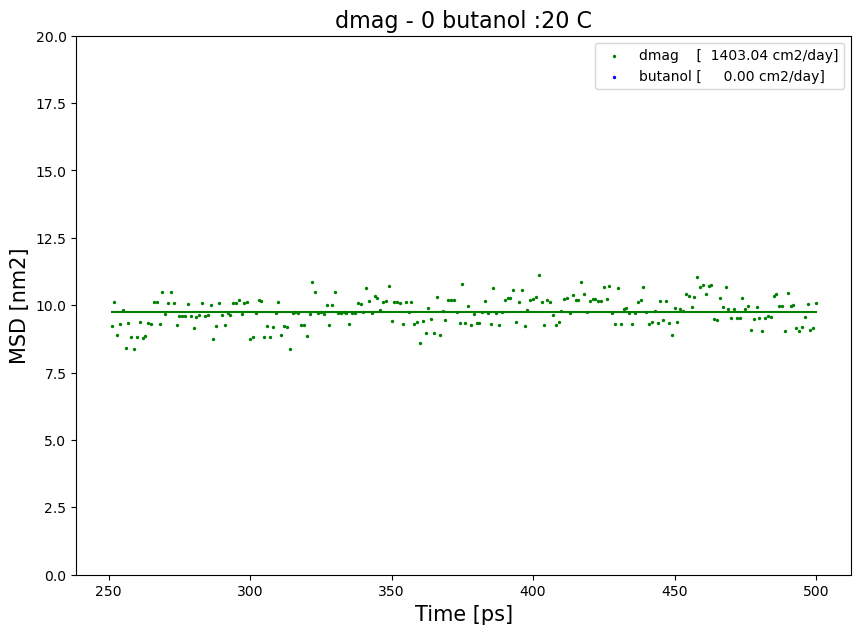

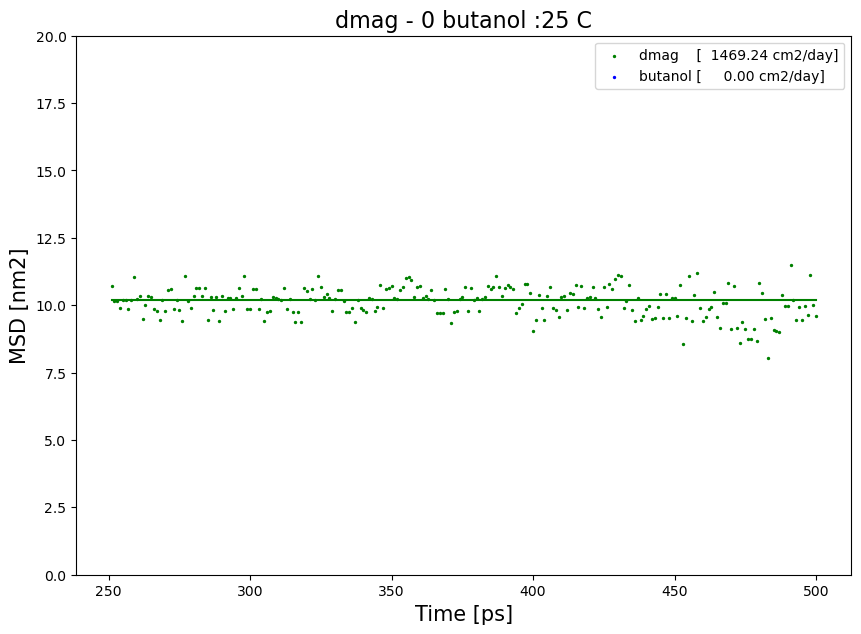

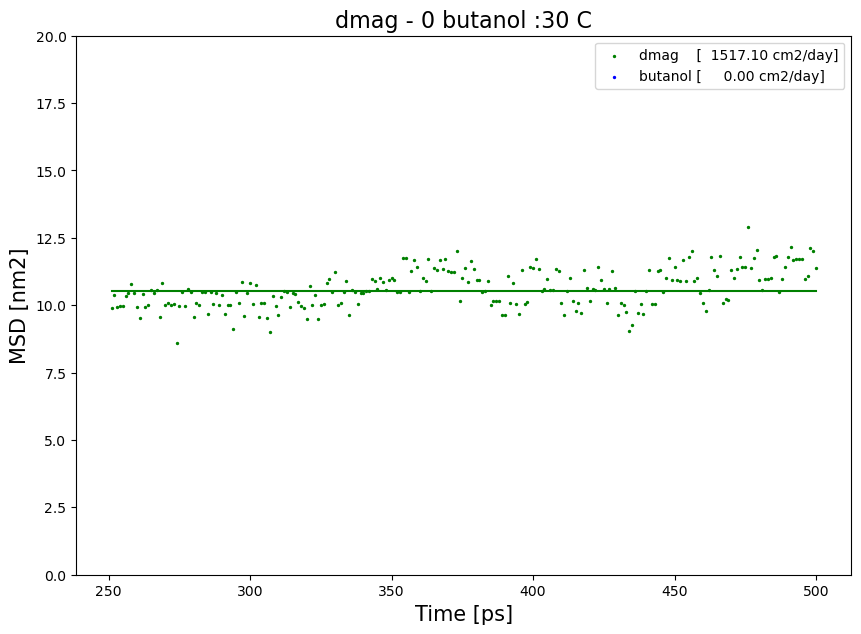

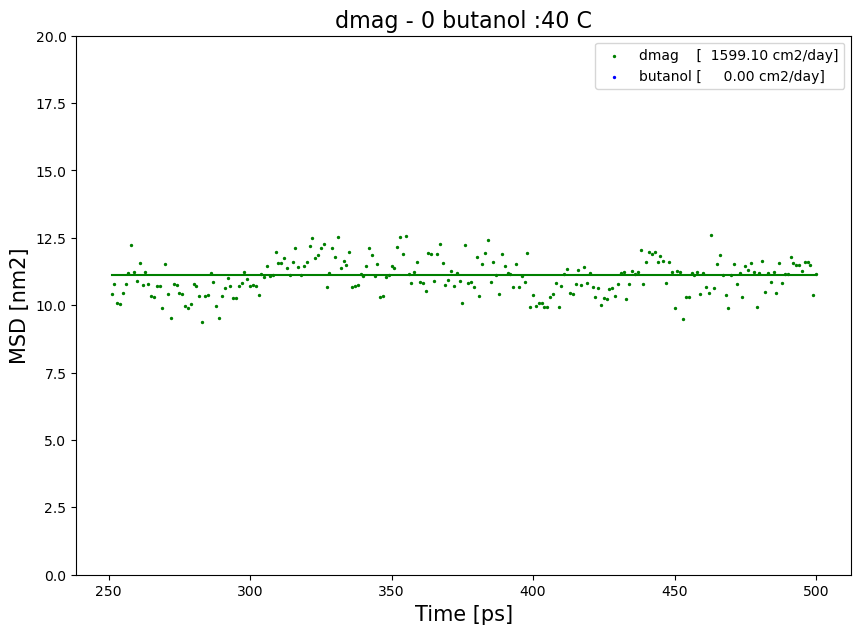

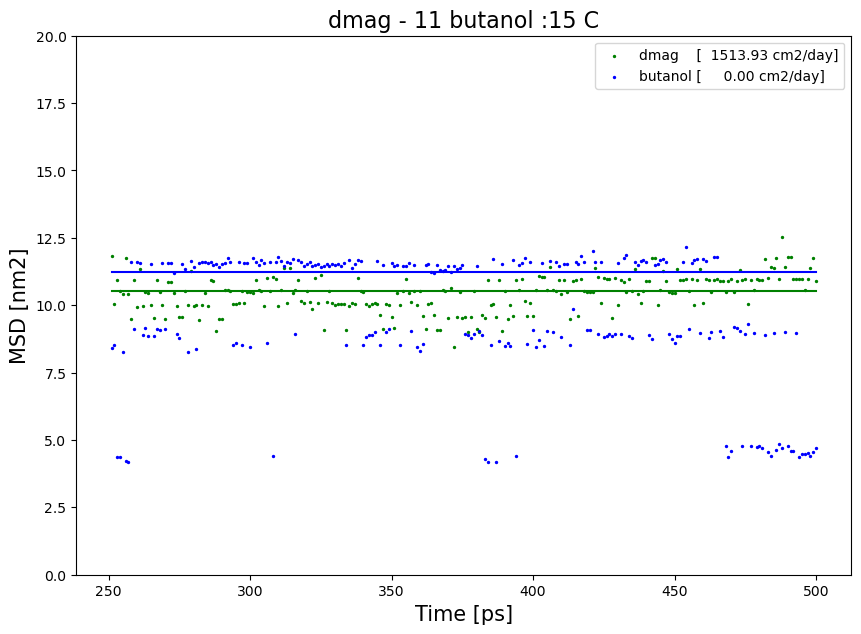

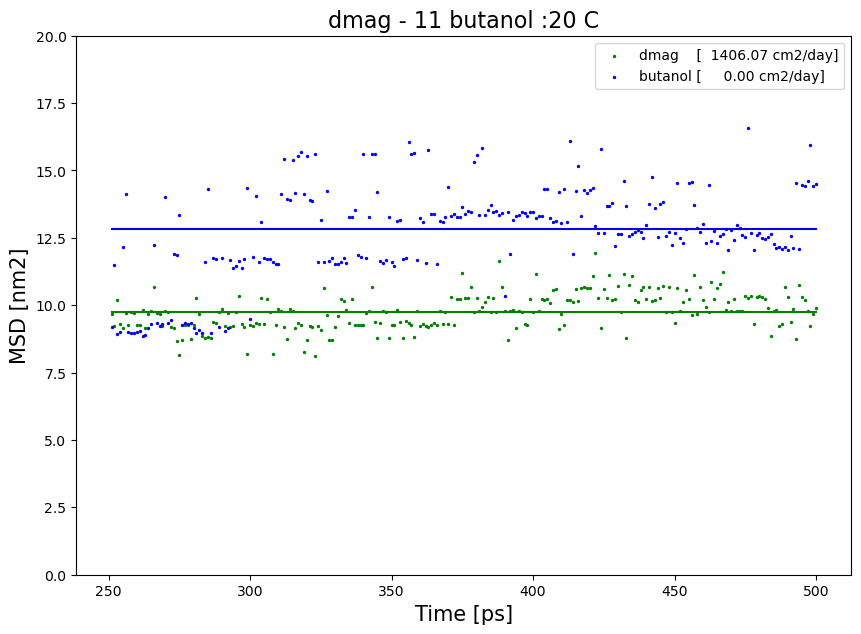

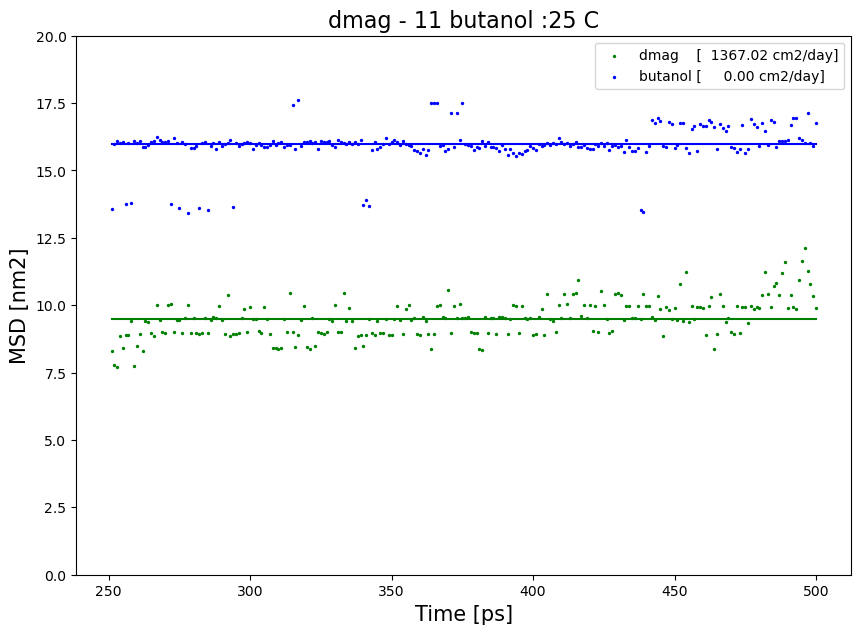

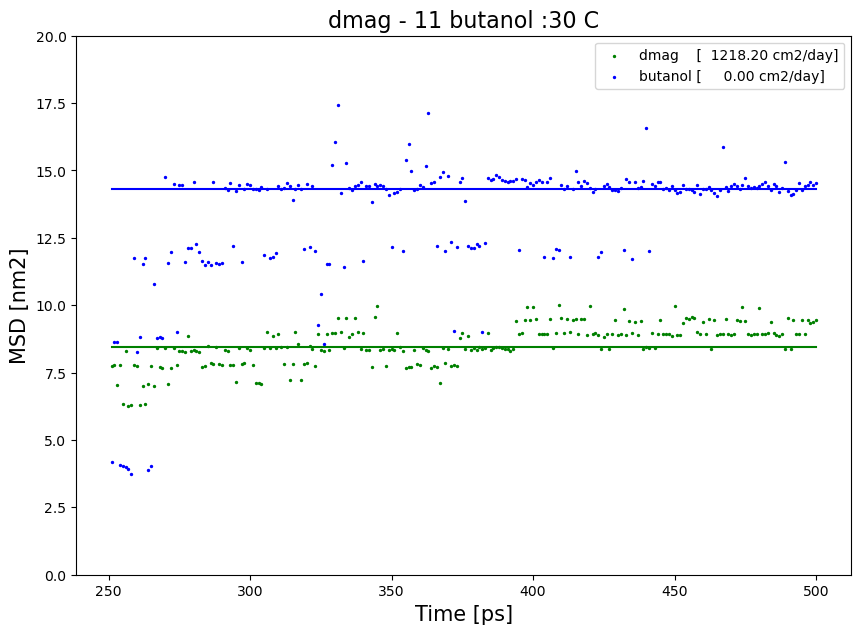

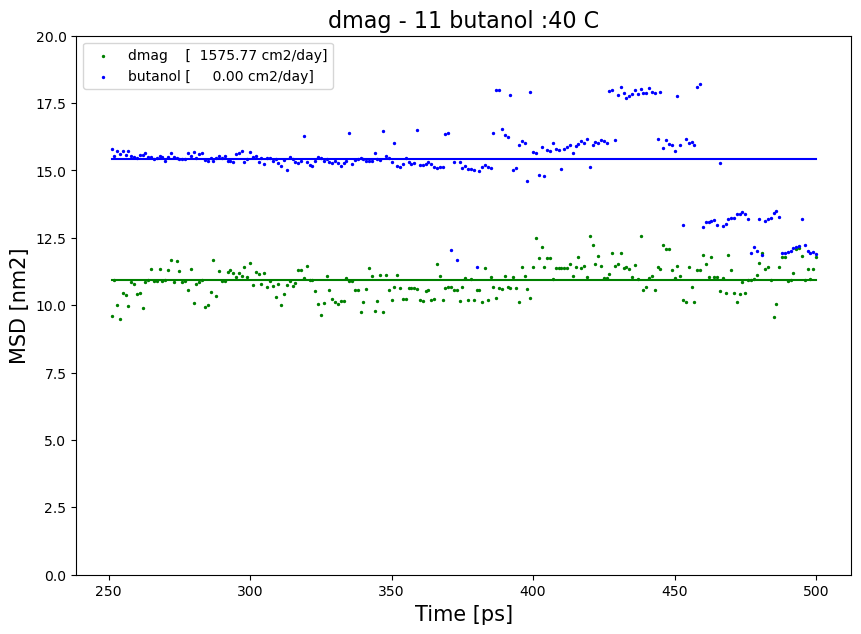

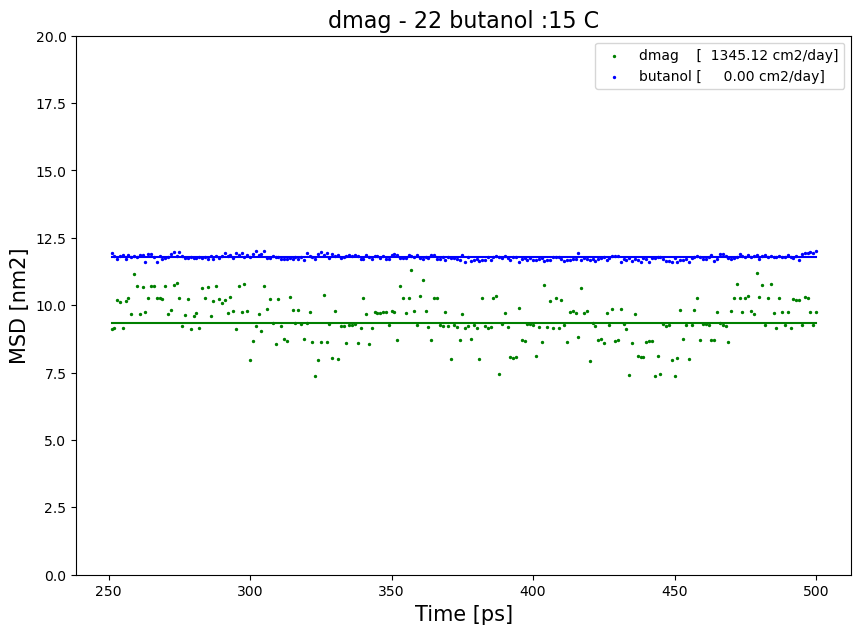

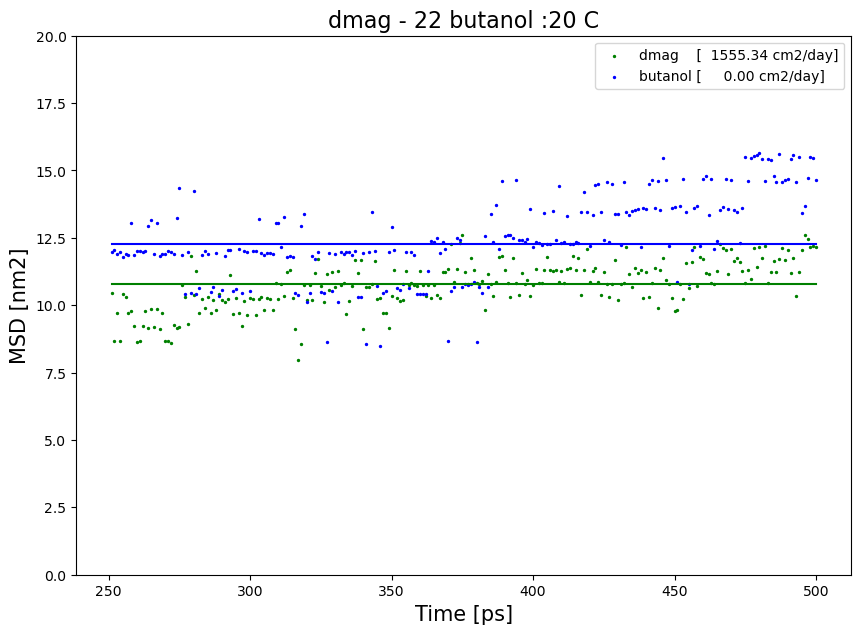

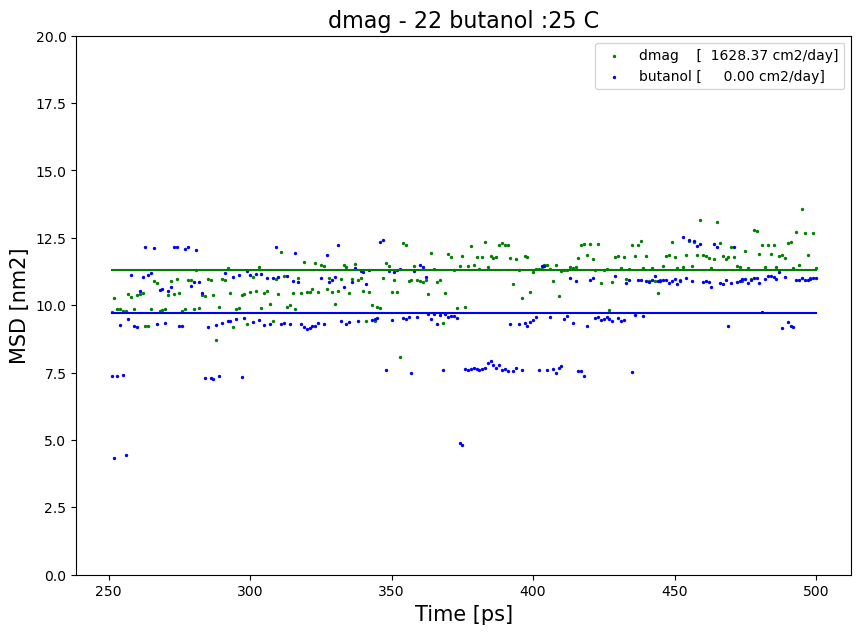

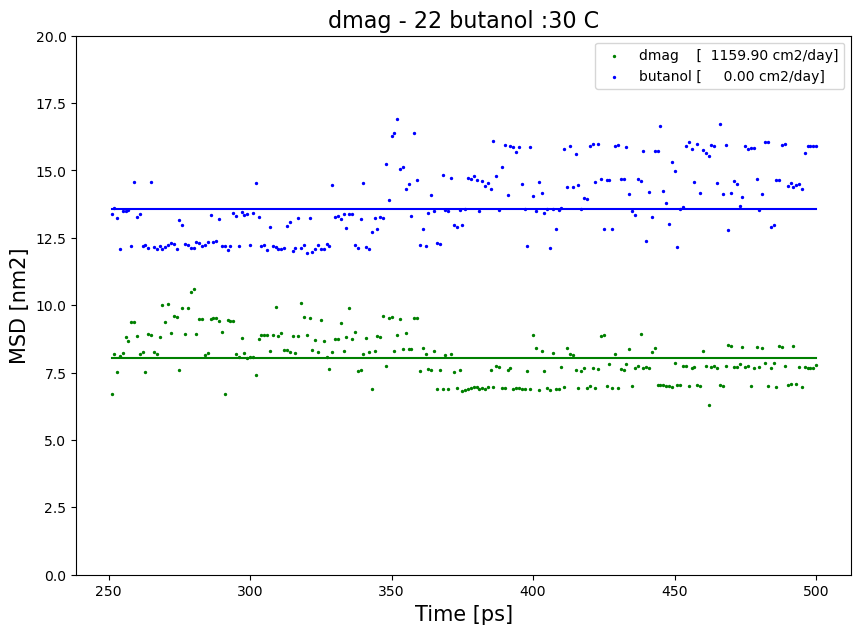

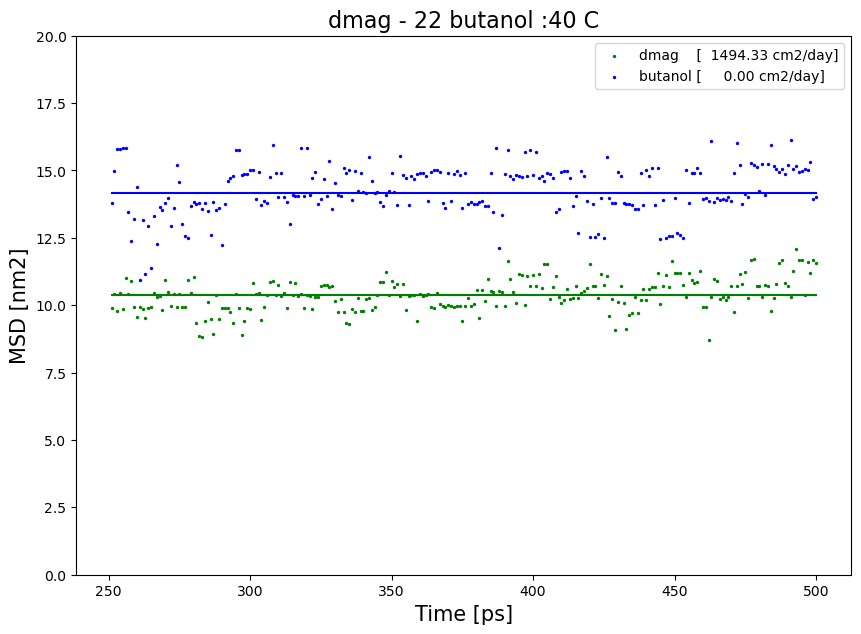

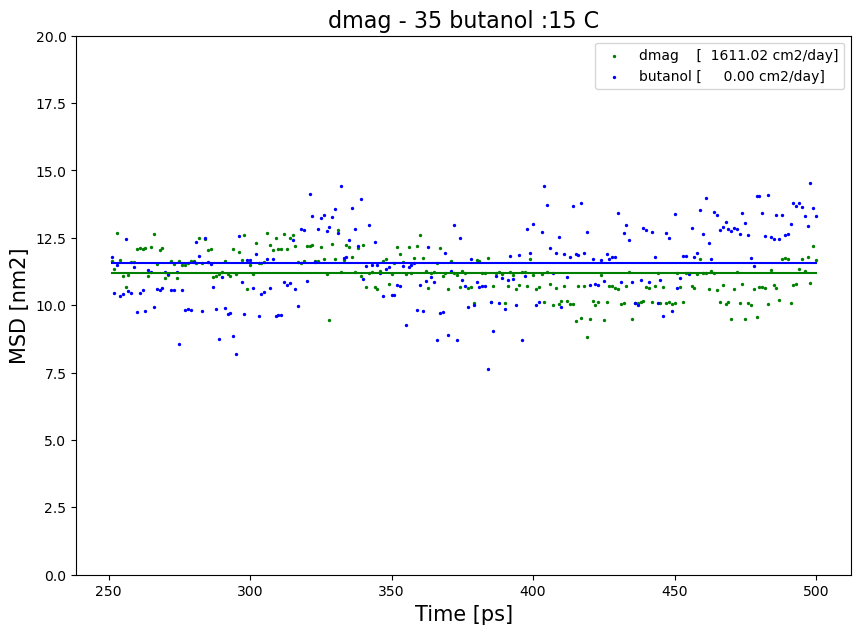

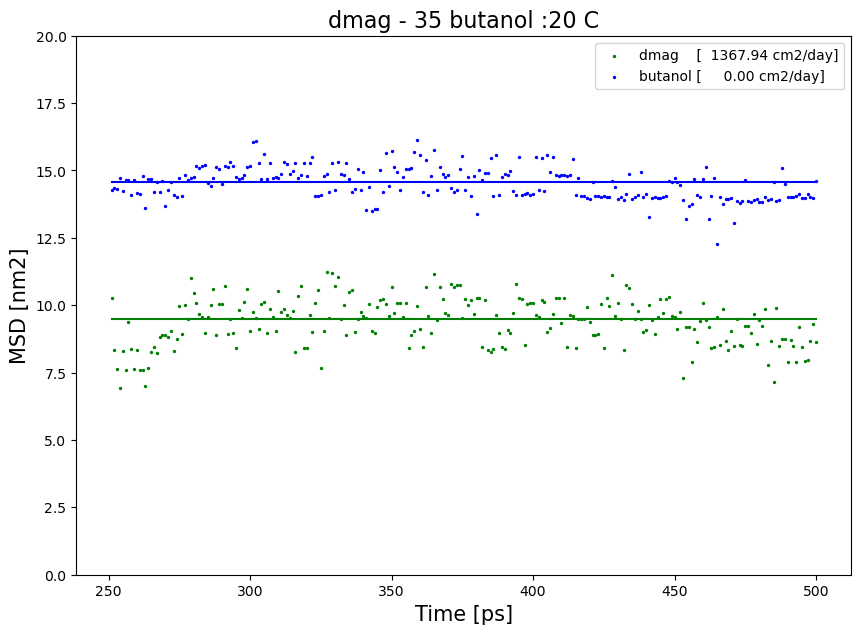

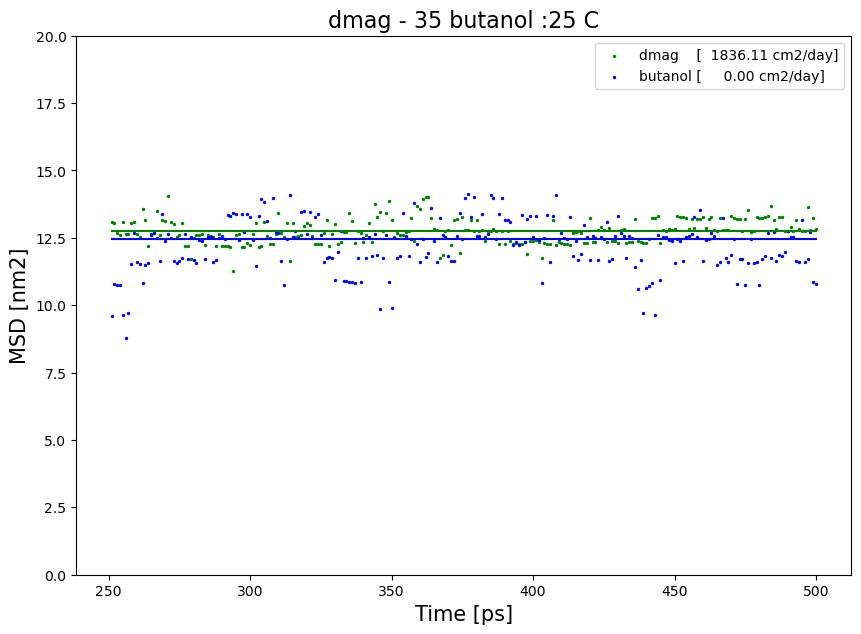

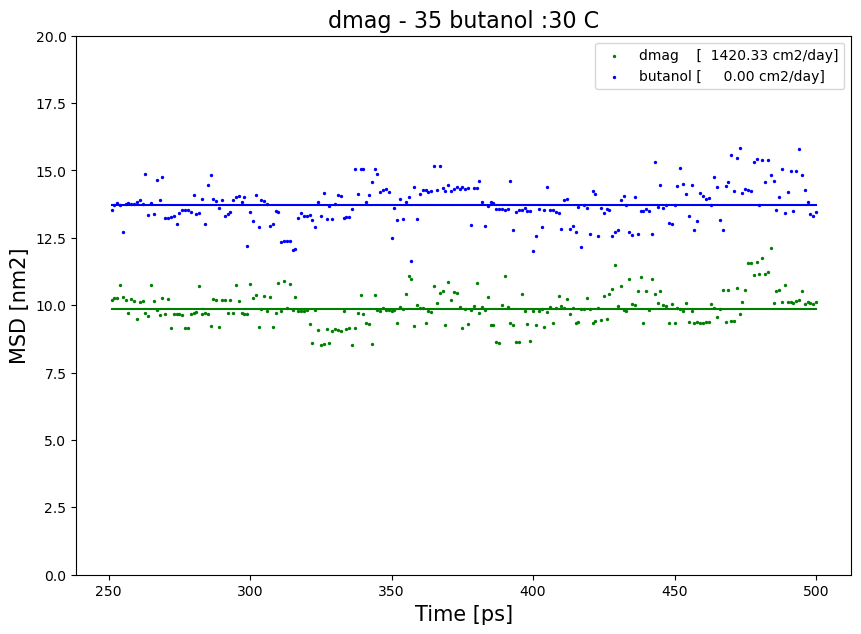

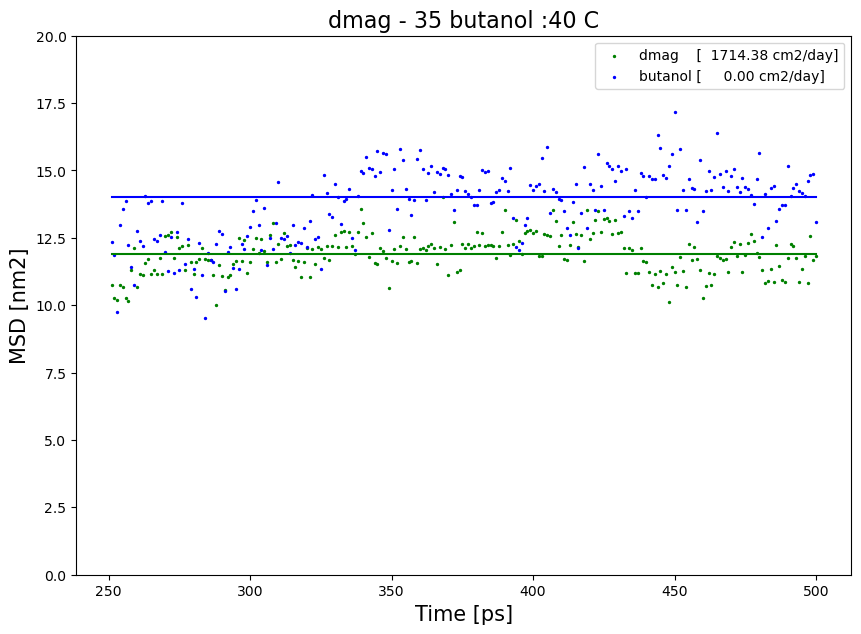

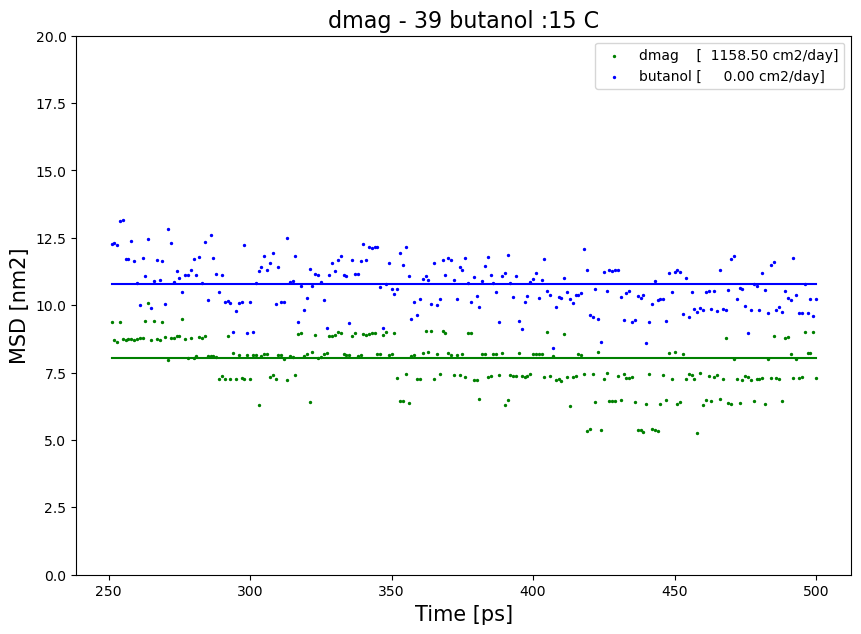

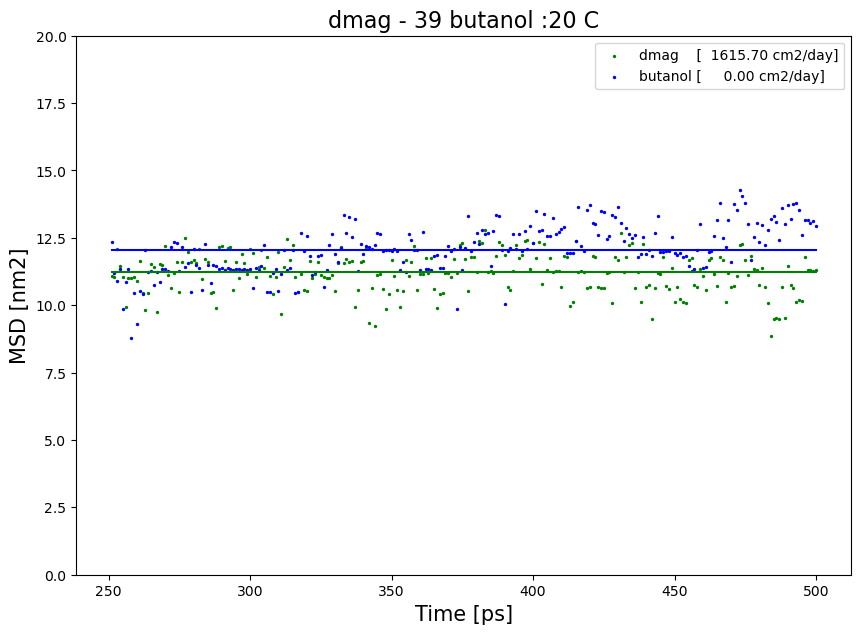

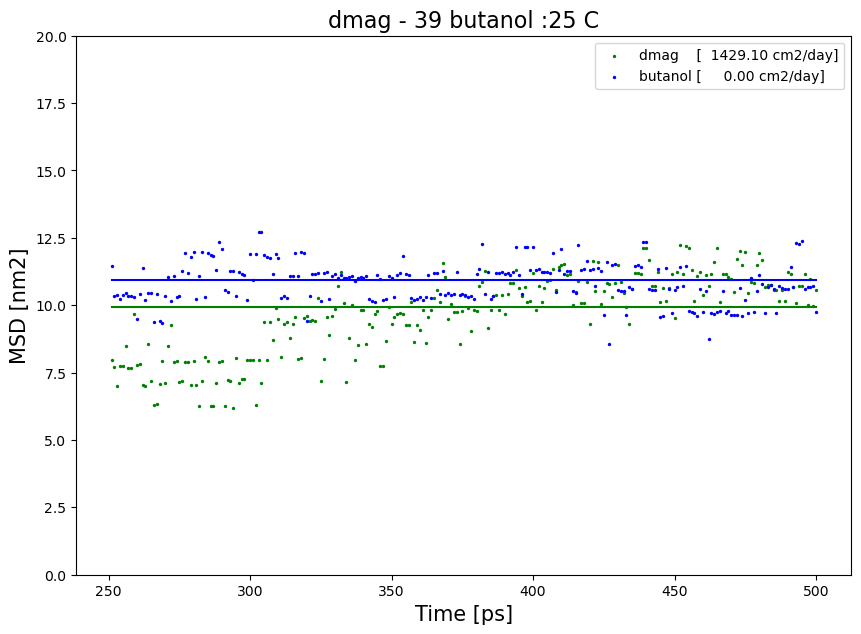

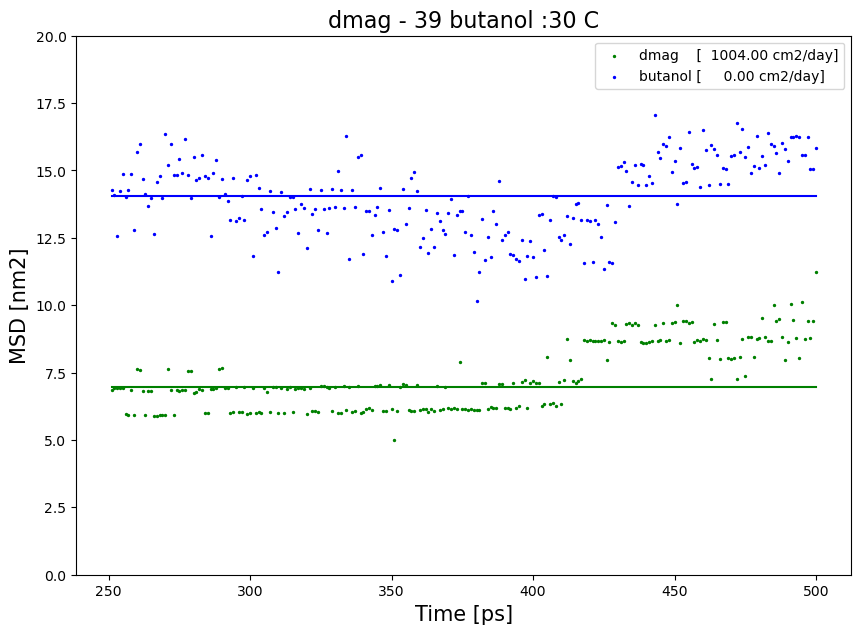

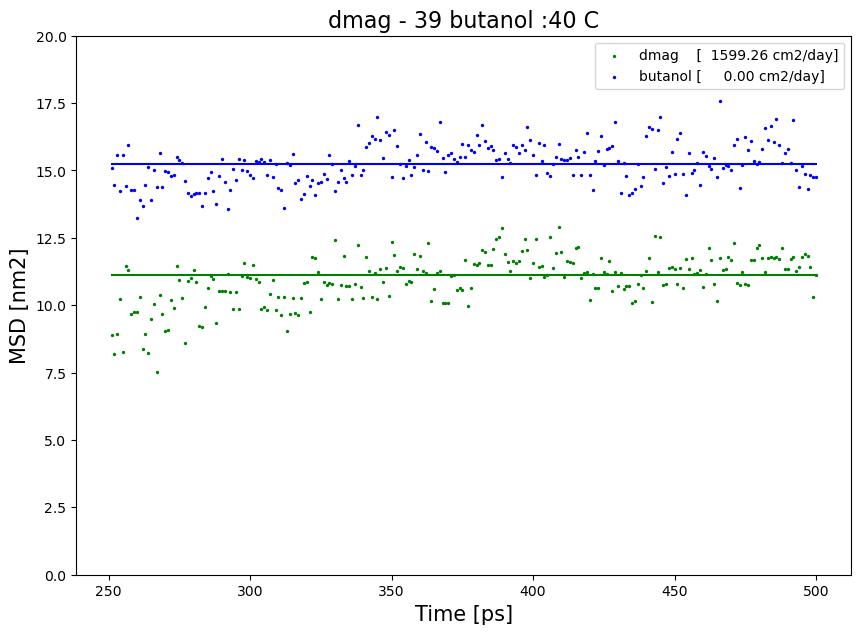

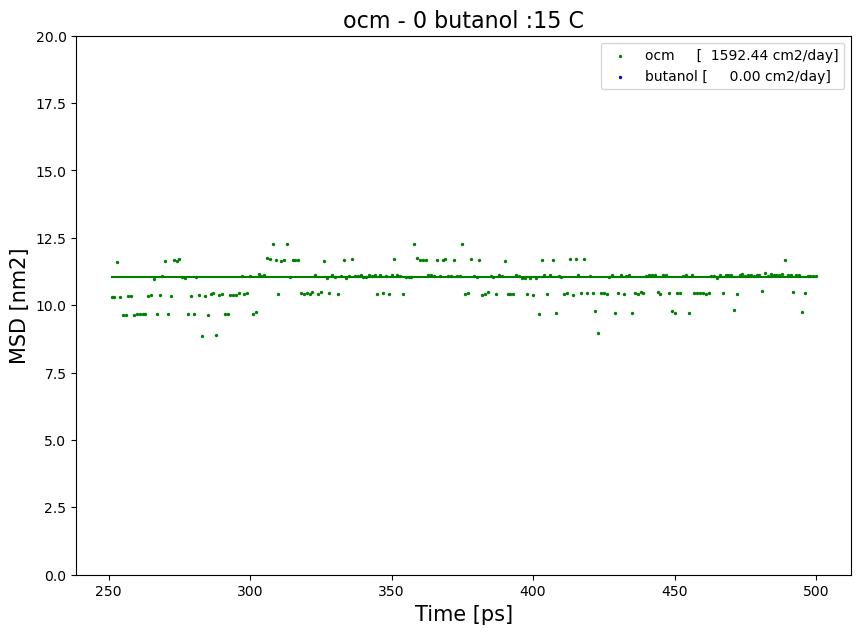

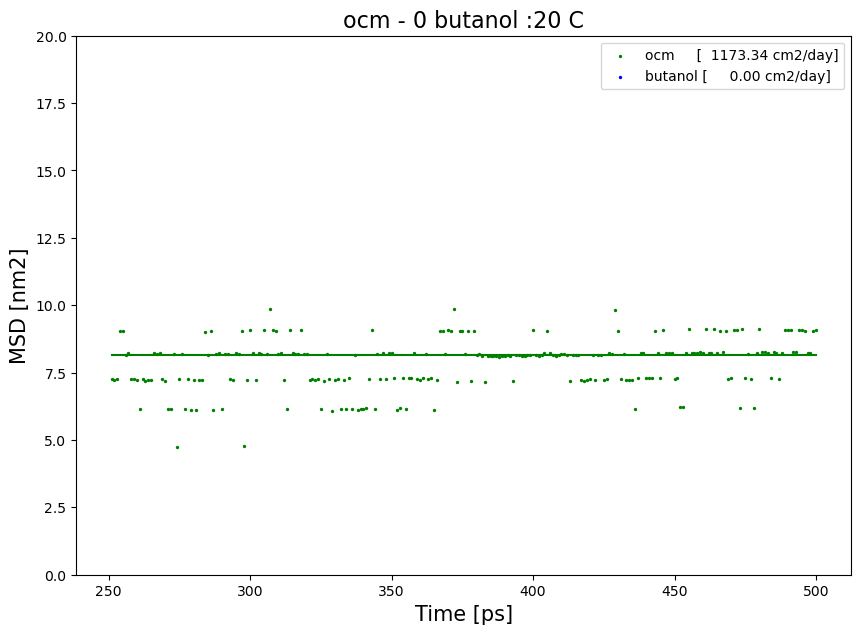

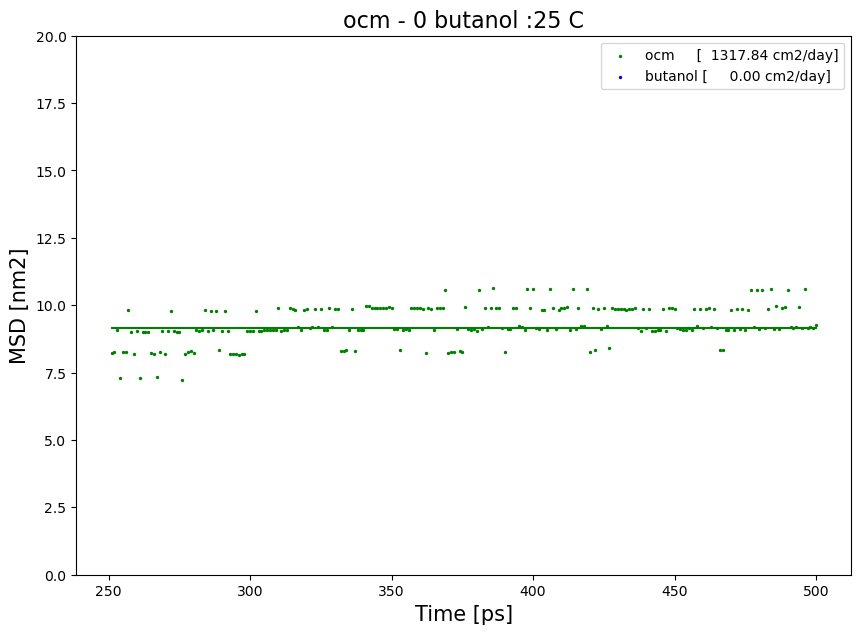

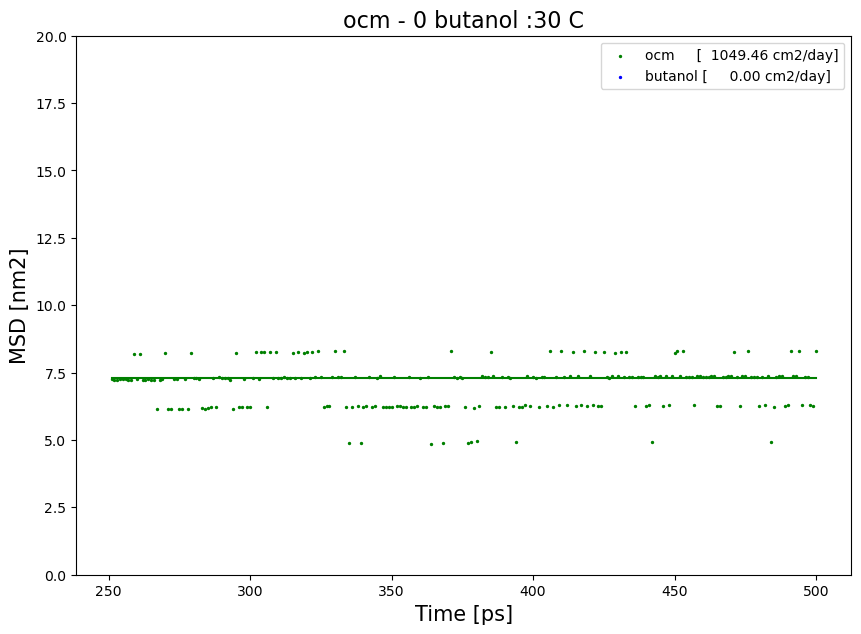

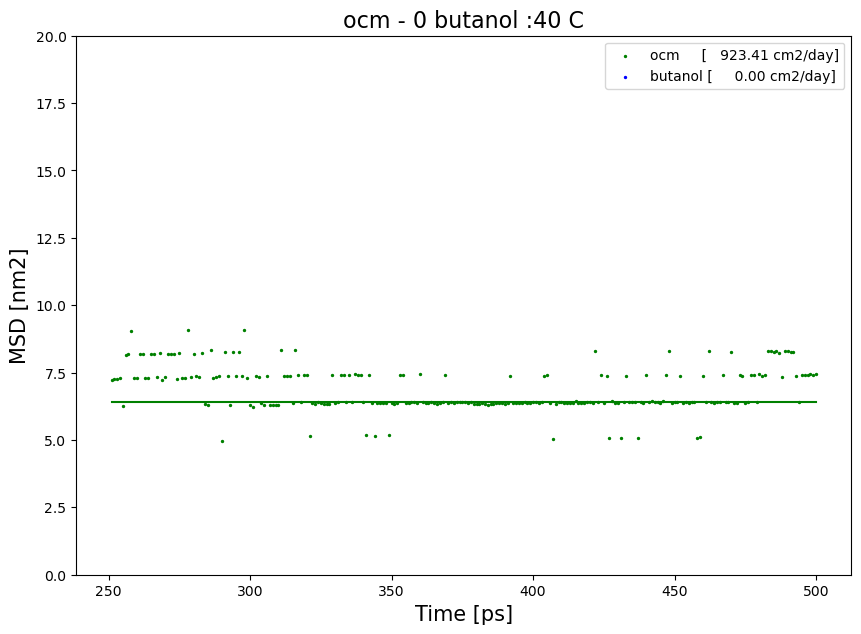

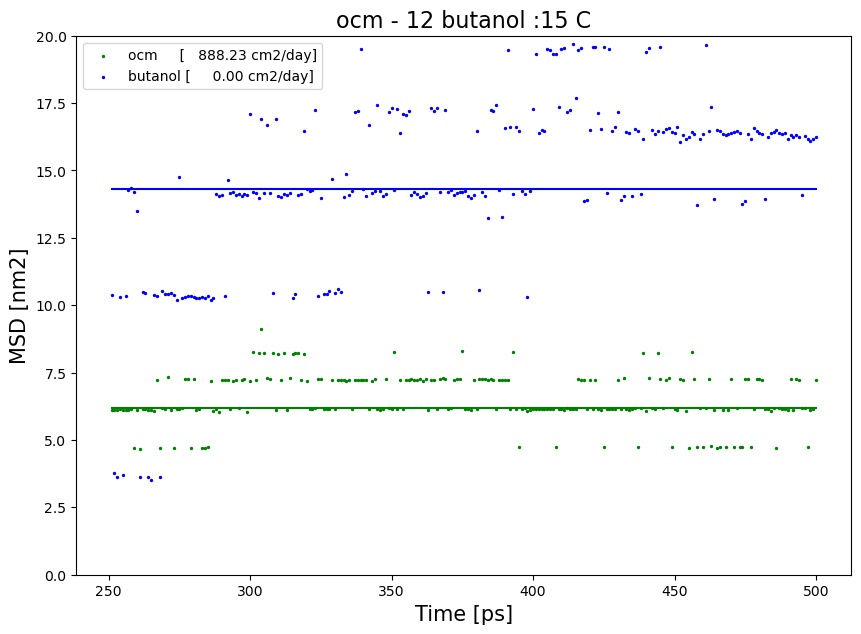

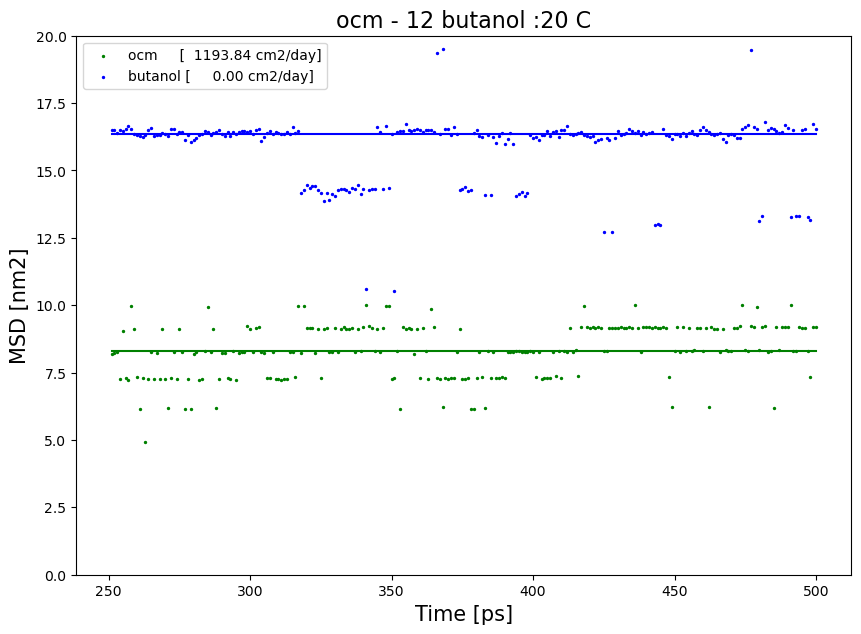

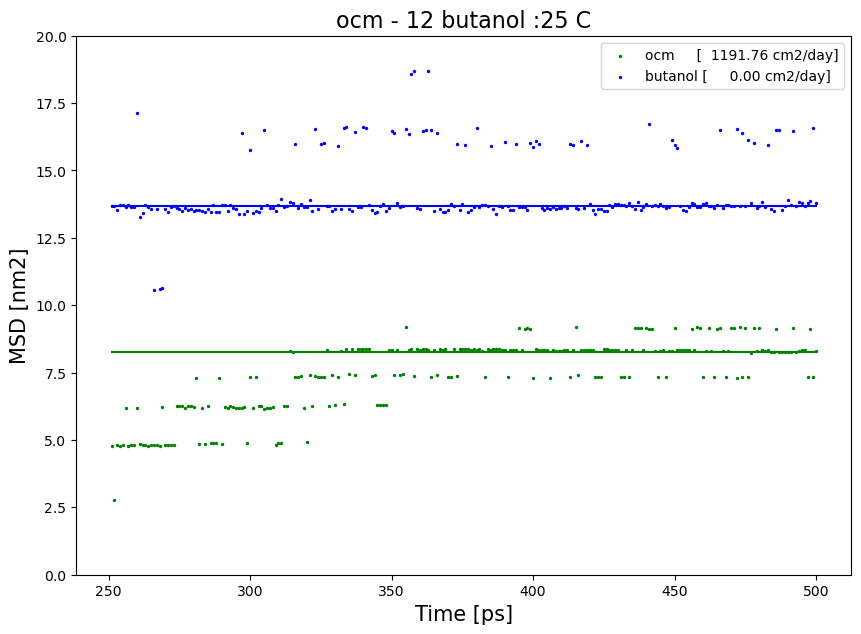

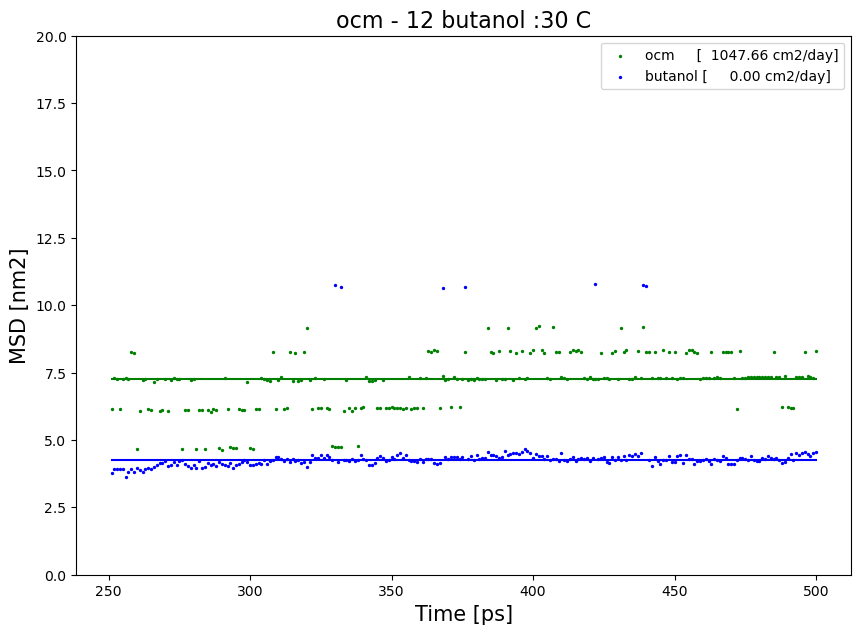

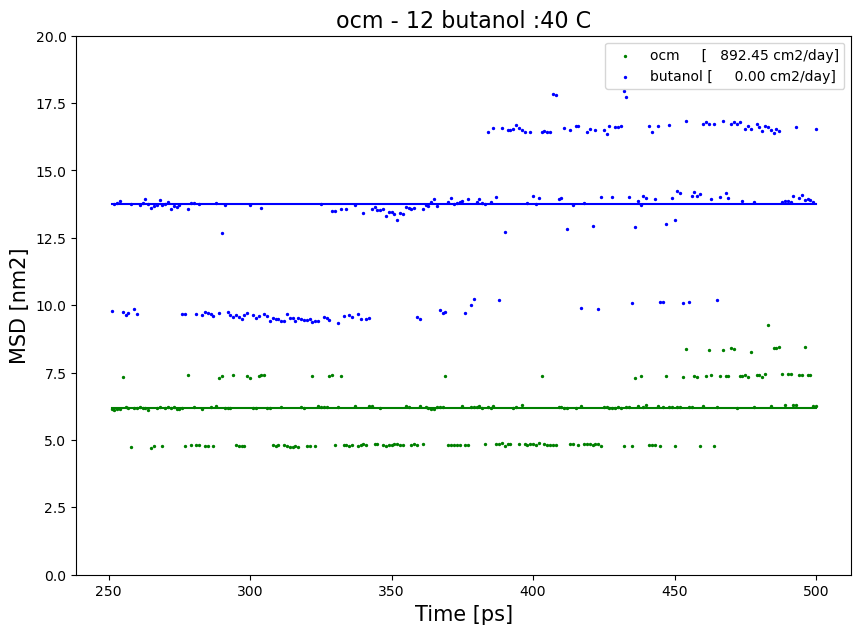

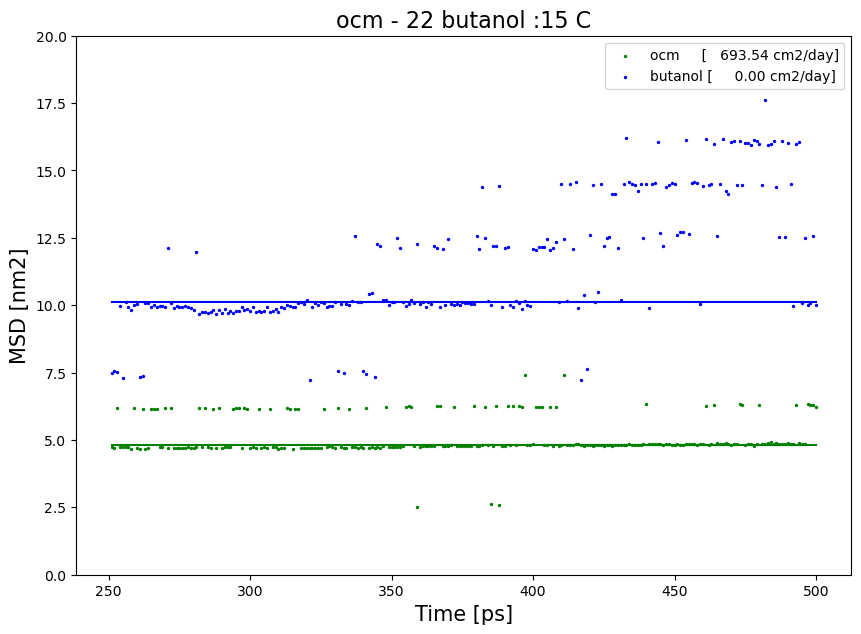

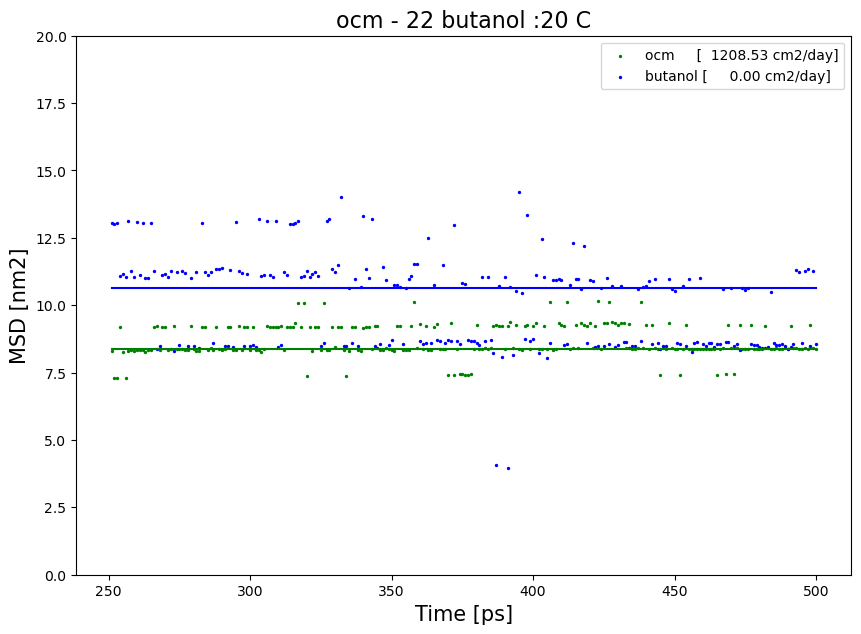

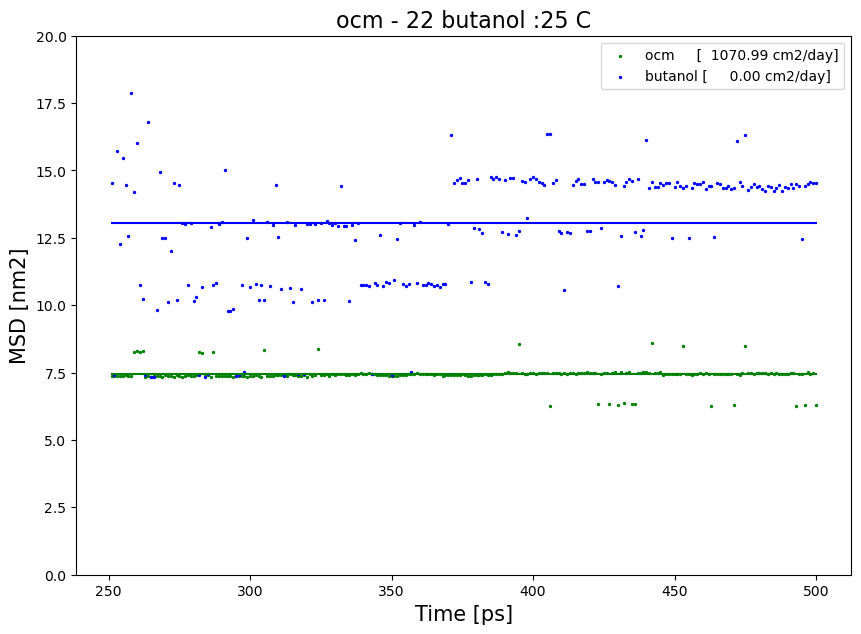

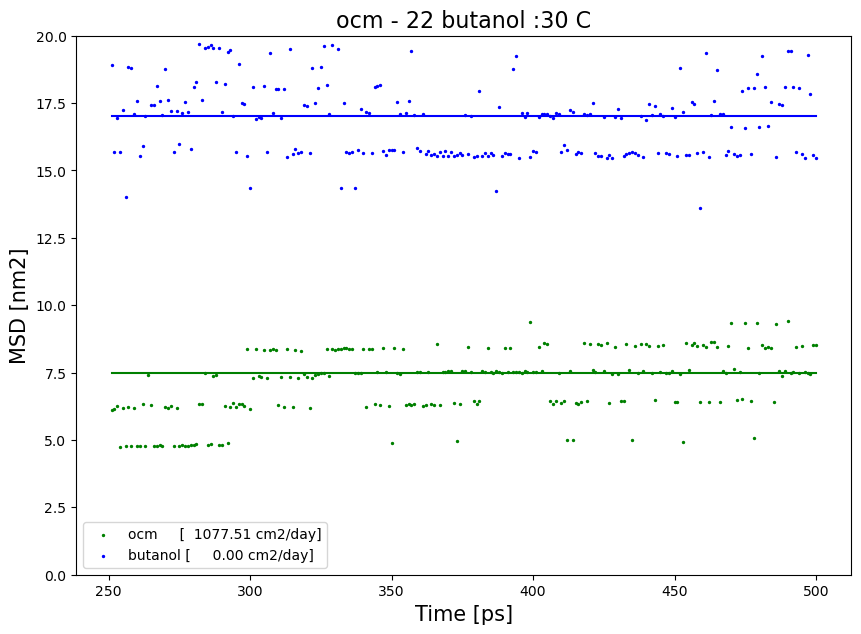

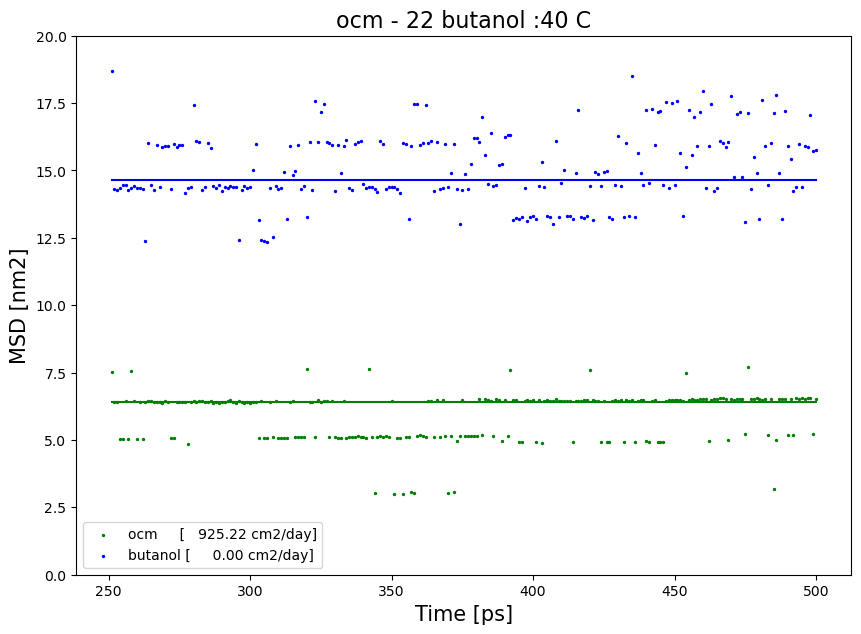

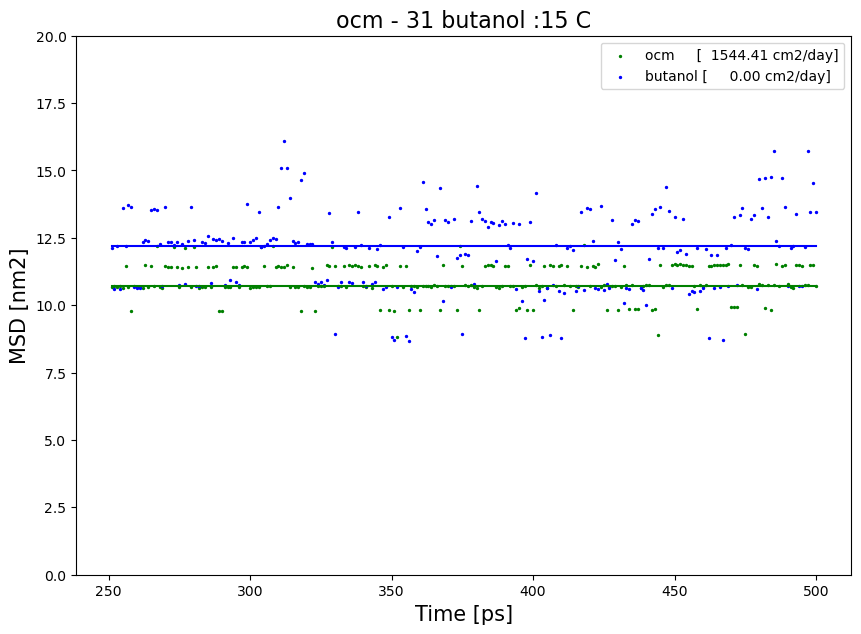

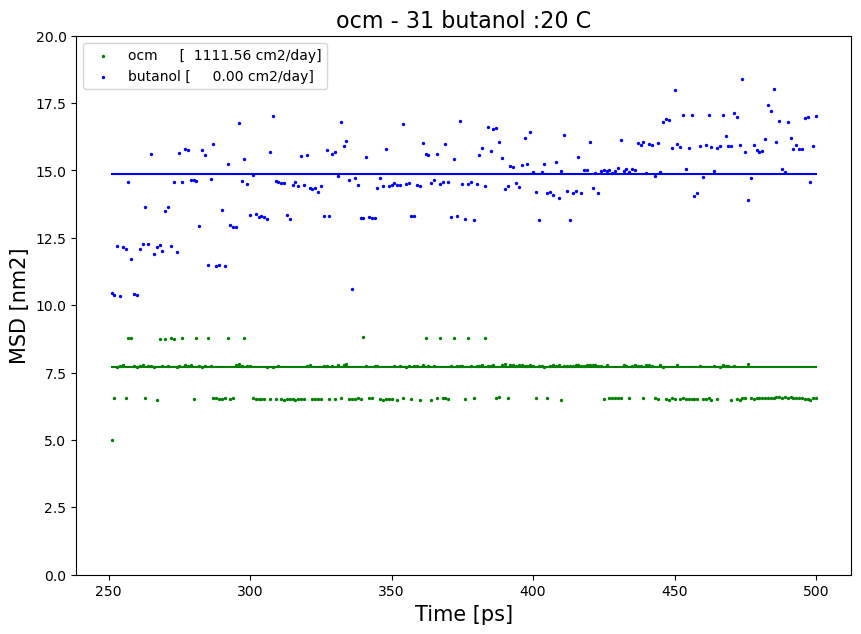

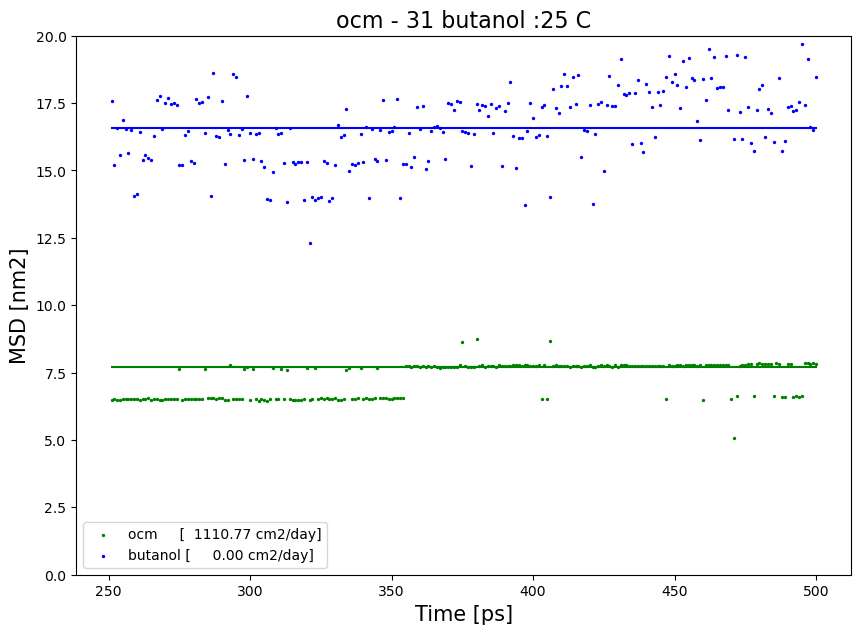

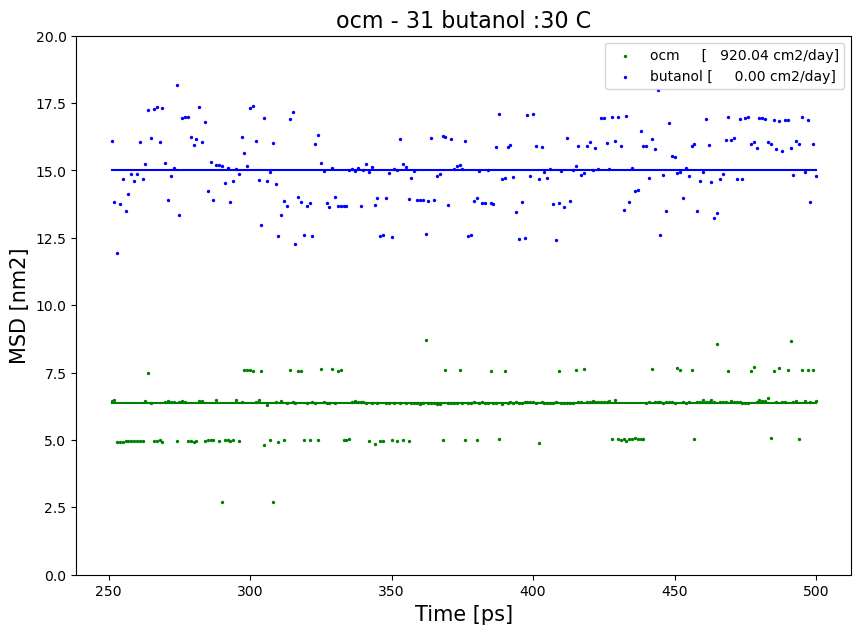

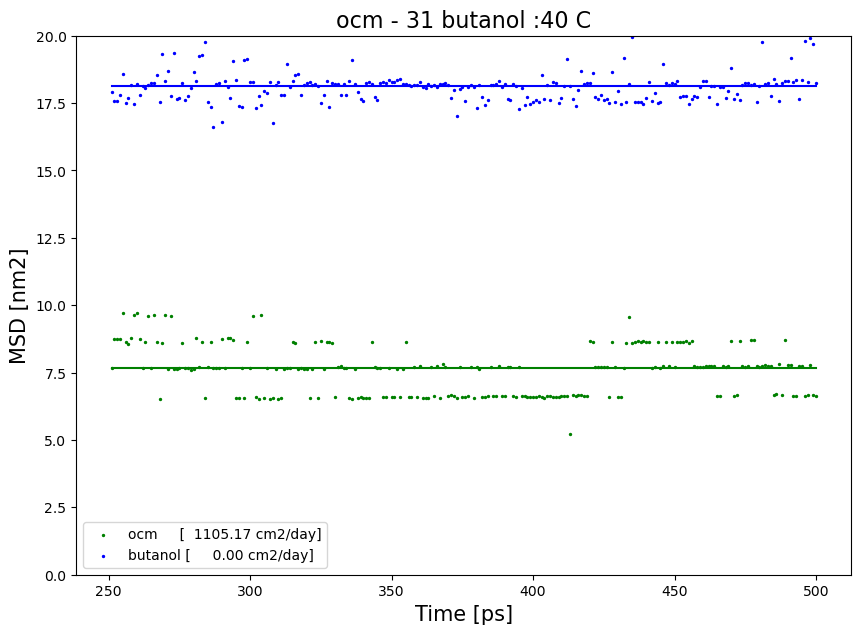

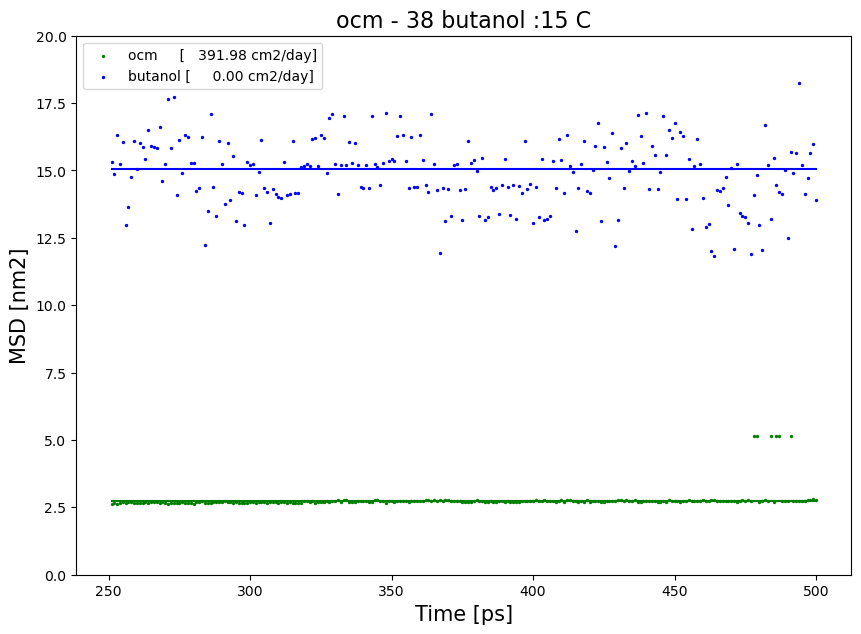

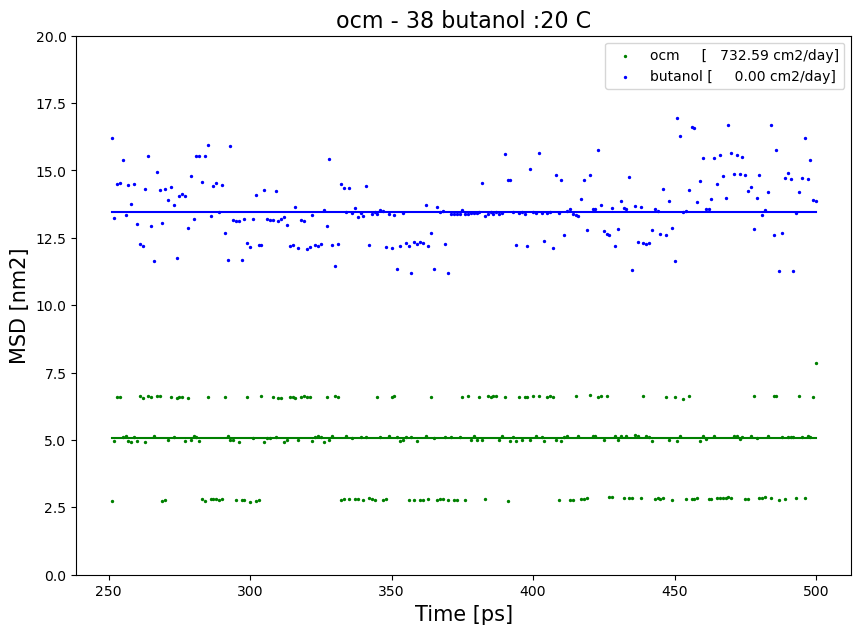

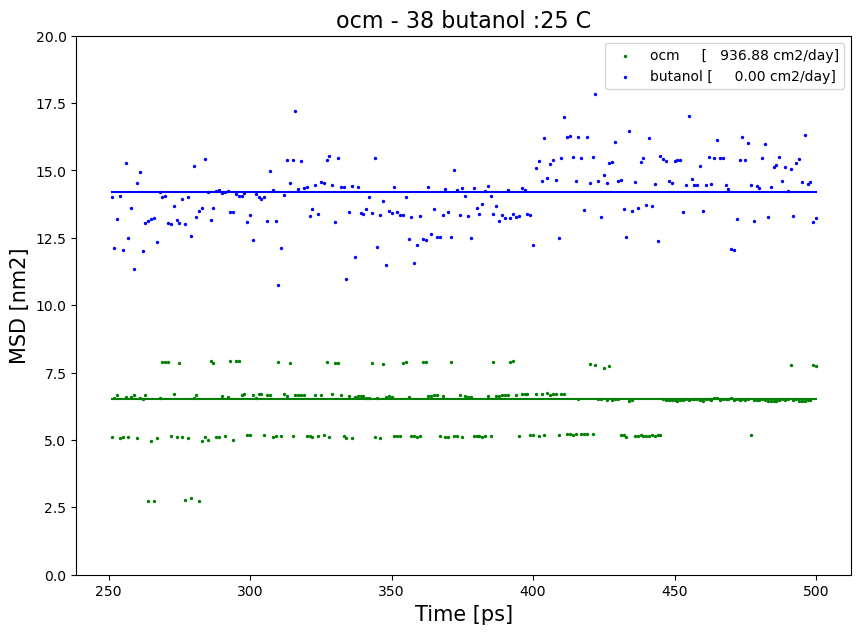

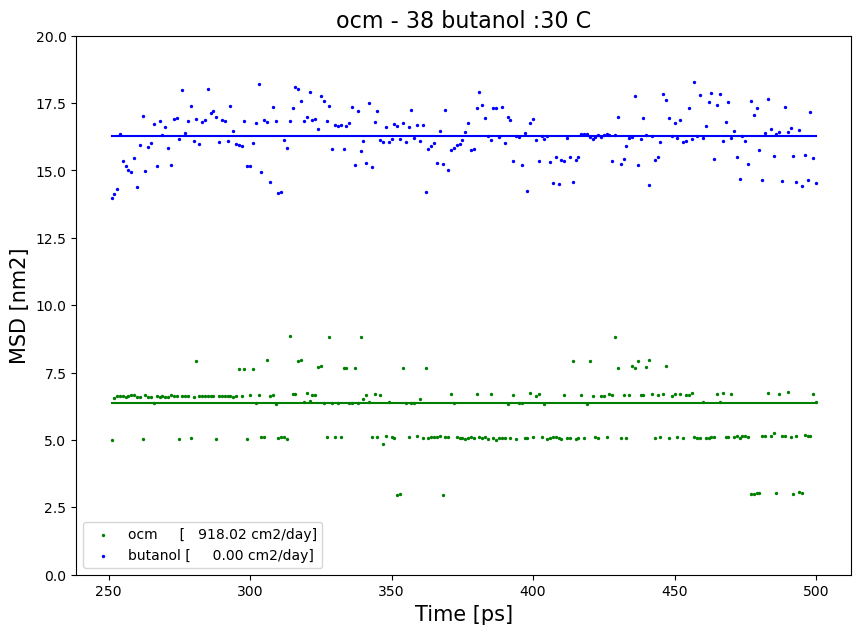

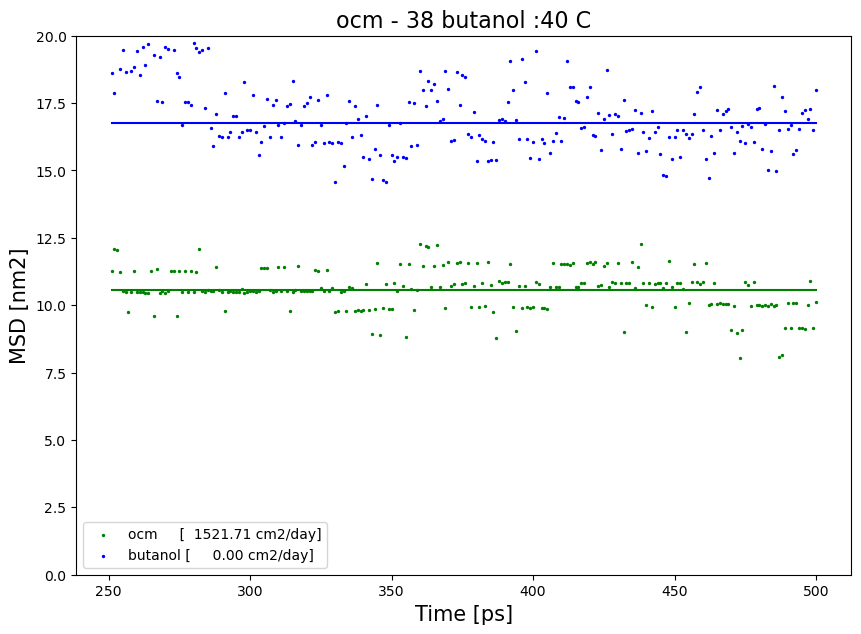

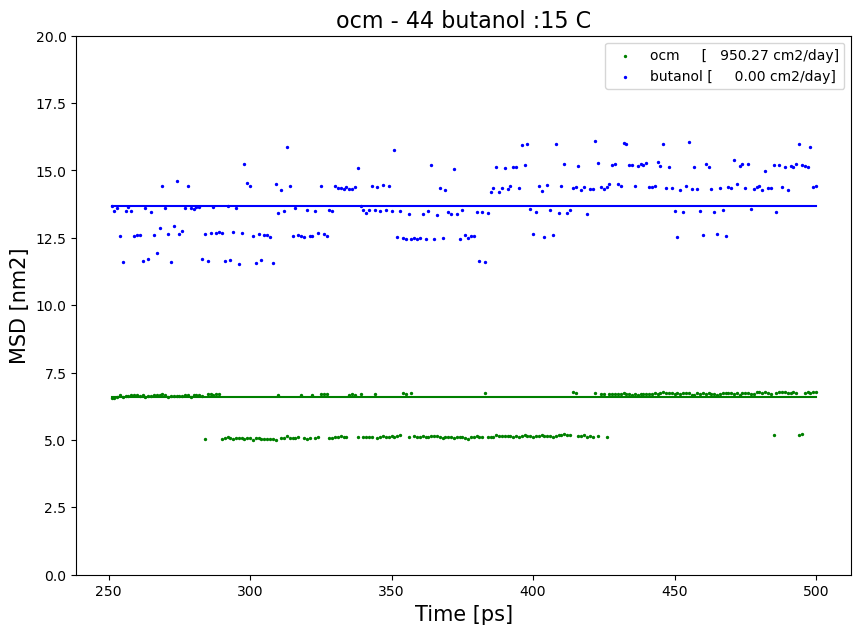

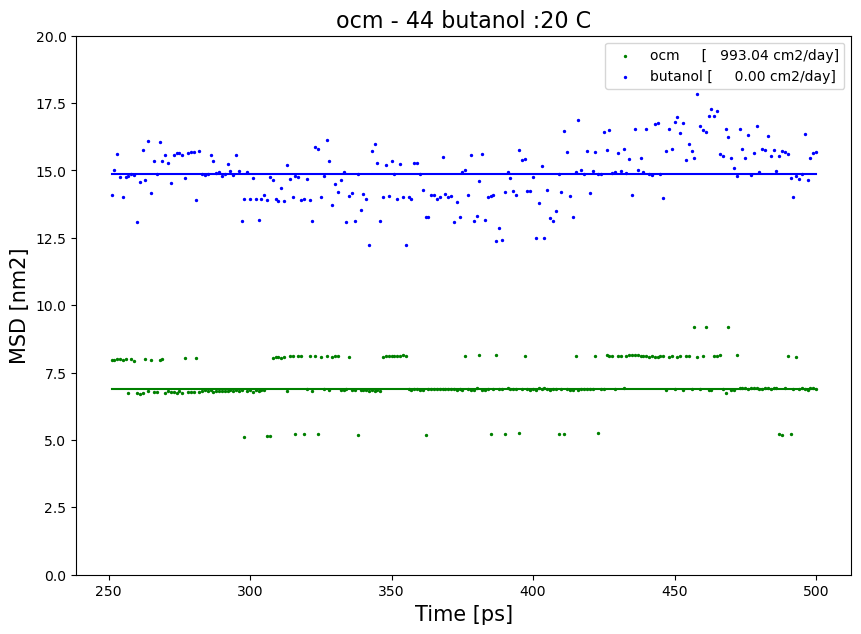

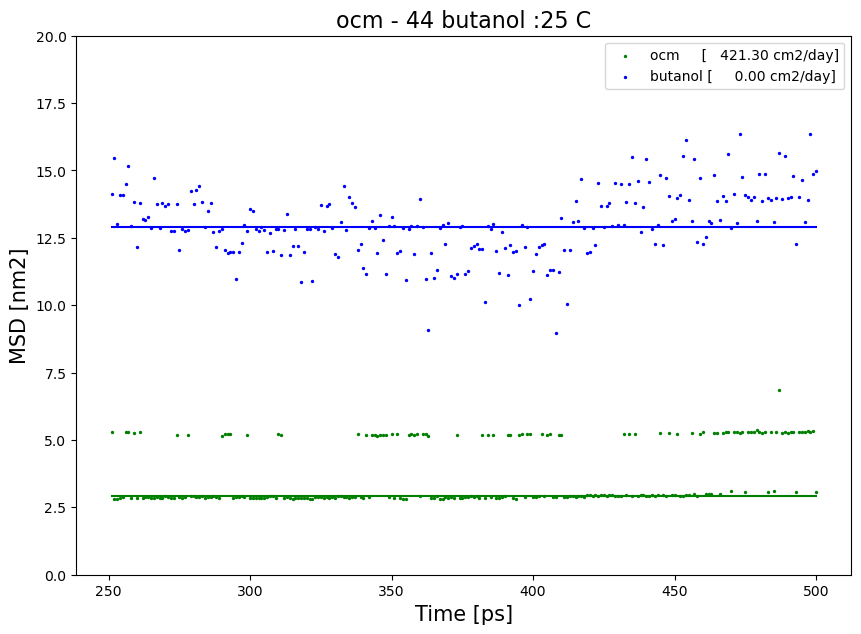

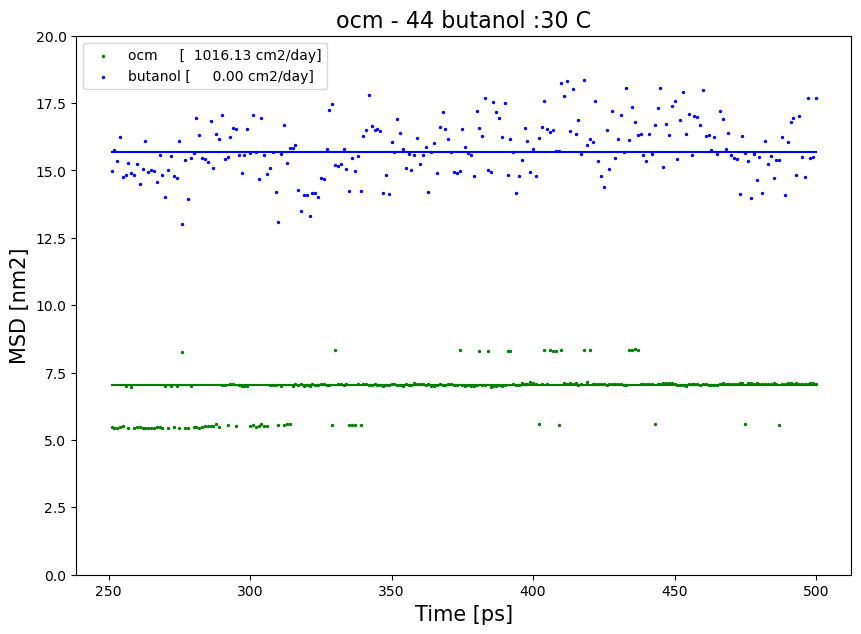

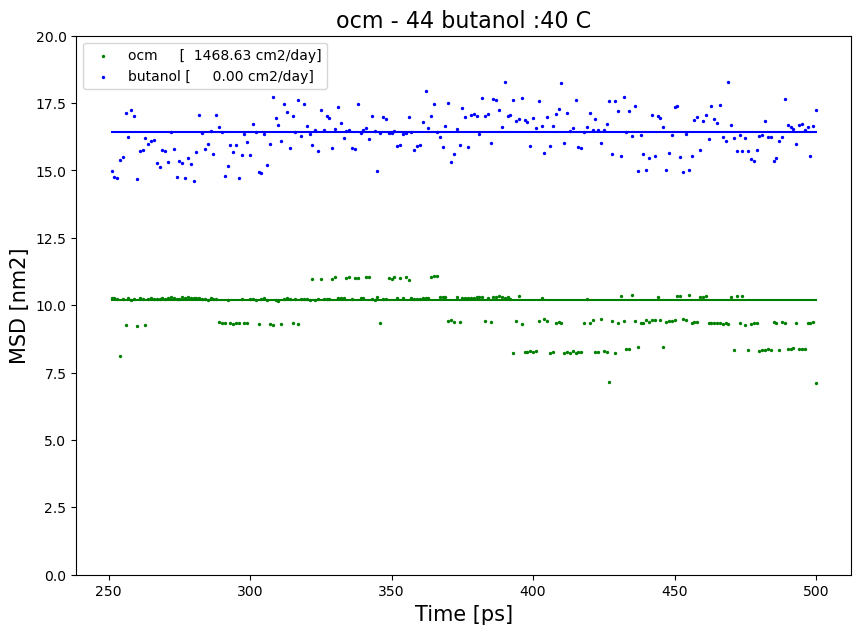

In [19]:
datas = []
D_data = []
plots_path = 'MSD_plots'
for directory in get_SysT_dir('results'):
    compound, x, rho = directory.parent.stem.split('_')
    T = directory.stem
    pdb = directory / 'Eq.pdb'
    traj = directory / 'traj.xtc'
    msd_path = directory / 'msd.csv'

    u = mda.Universe(pdb, traj)
    # df = from_mda(u, compound)
    # df = from_MSD(msd_path, compound)
    # S, S0 = regress(df)
    # D = S / 6 * 24 * 60 * 60

    df = strict(get_RMSD(u, compound))
    S, S0 = 0, df.iloc[:, 1].median()
    D = S0 * 1e12 / 1e14 / 6 * 24 * 60 * 60

    # df_but = from_mda(u, 'butanol')
    # df_but = from_MSD(msd_path, compound)
    # S_but, S0_but = regress(df_but)
    # D_but = S_but / 6 * 24 * 60 * 60

    df_but = strict(get_RMSD(u, 'butanol'))
    S_but, S0_but = 0, df_but.iloc[:, 1].median()
    D_but = S_but * 1e12 / 1e14 / 6 * 24 * 60 * 60

    fig, ax = plt.subplots()
    ax.set_ylabel('MSD [nm2]')
    ax.set_xlabel('Time [ps]')
    # y_scaller = 1e14
    # x_scaller = 1e12
    # ax.set_ylim(0, 3)
    y_scaller = 1
    x_scaller = 1
    ax.set_ylim(0, 20)

    time = df['Time']
    time_but = df_but['Time']
    ax.scatter(
        time * x_scaller,
        df.iloc[:, 1] * y_scaller,
        label=f'{compound:7} [{D: 9.2f} cm2/day]',
        c='g',
        s=2,
    )
    ax.plot(time * x_scaller, (S * time + S0) * y_scaller, 'g')
    ax.scatter(
        time_but * x_scaller,
        df_but.iloc[:, 1] * y_scaller,
        label=f'butanol [{D_but: 9.2f} cm2/day]',
        c='b',
        s=2,
    )
    ax.plot(time_but * x_scaller, (S_but * time_but + S0_but) * y_scaller, 'b-')
    ax.legend()

    ax.set_title(f"{compound} - {x} butanol :{T} C")
    Path(plots_path).mkdir(parents=True, exist_ok=True)
    fig.savefig(Path(plots_path) / f"{compound}_{x}_{T}.jpg", dpi=600)

    # datas.append({''})
# Ds = pd.DataFrame(D_data)

In [12]:
DF = collect()

In [7]:
DF_D = extract_D(DF)
DF_D

,substance,x,T,D_substance,D_butanol
0,BUT,100,15,0.289796,0.289796
1,BUT,100,20,0.465019,0.465019
2,BUT,100,25,0.566347,0.566347
3,BUT,100,30,0.686457,0.686457
4,BUT,100,40,0.746760,0.746760
...,...,...,...,...,...
86,PET,30,20,0.005769,0.006510
87,PET,30,25,0.004693,0.008029
88,PET,30,30,0.003073,0.013351
89,PET,30,40,0.005467,0.011967


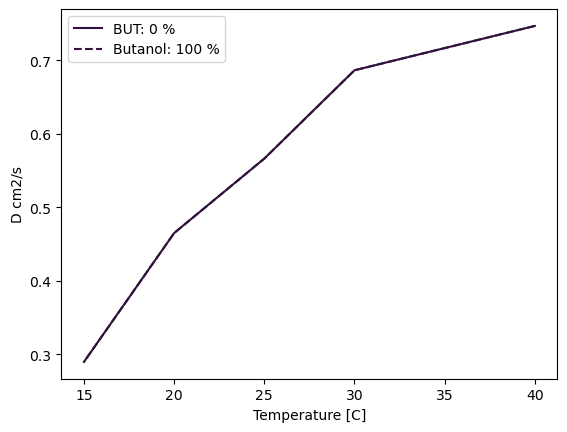

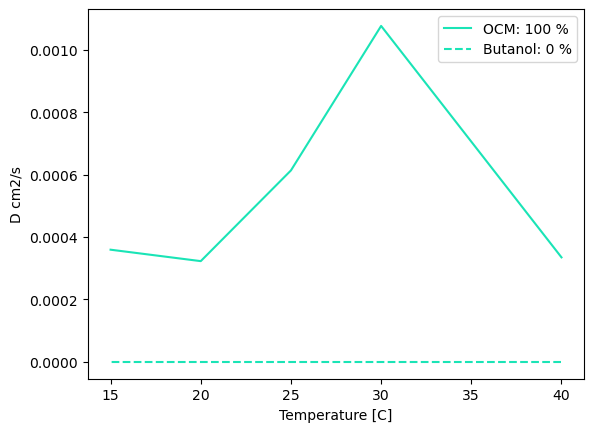

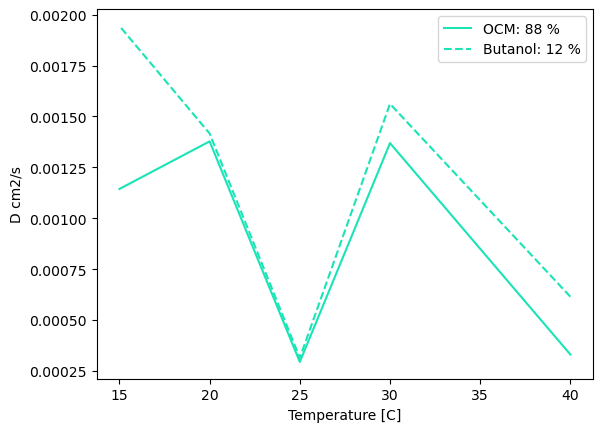

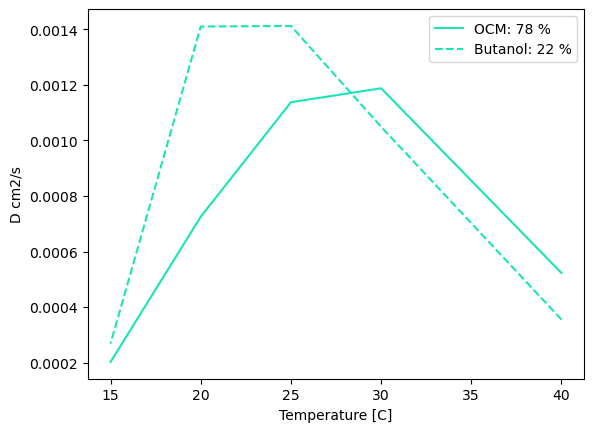

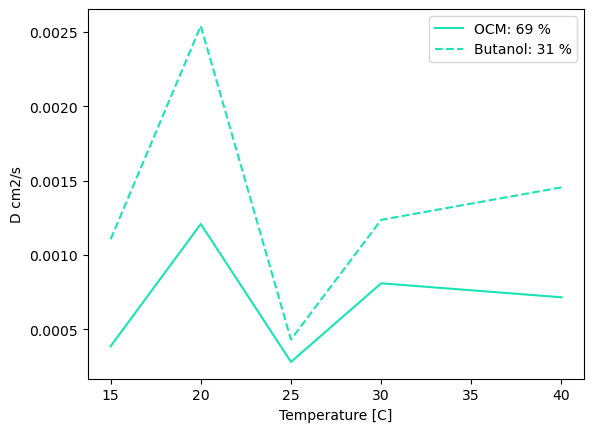

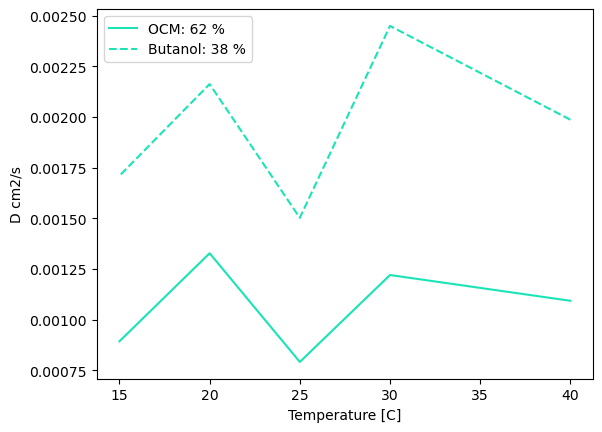

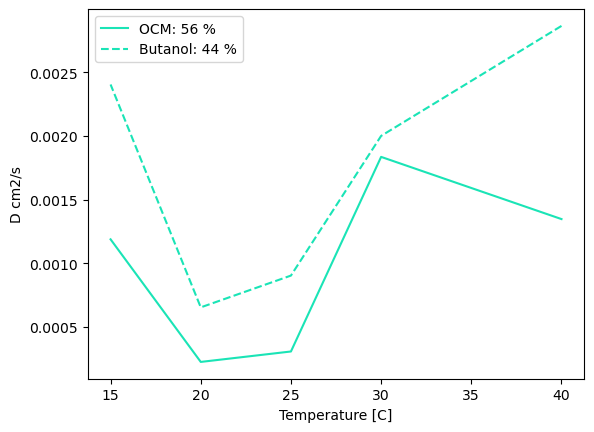

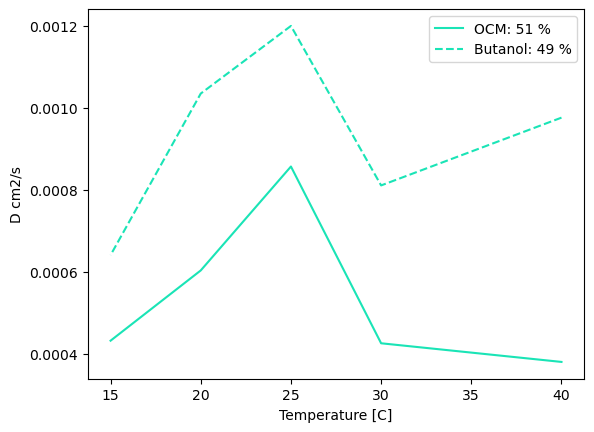

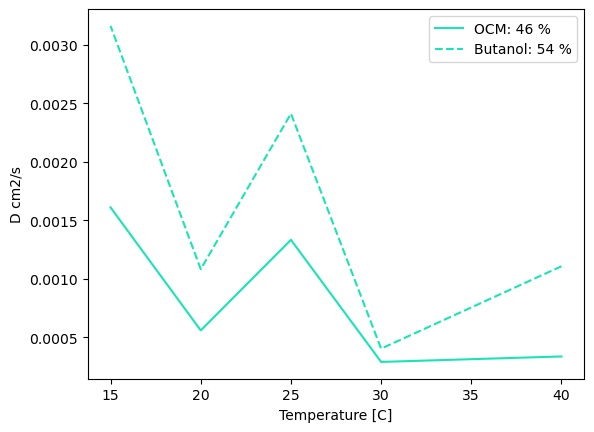

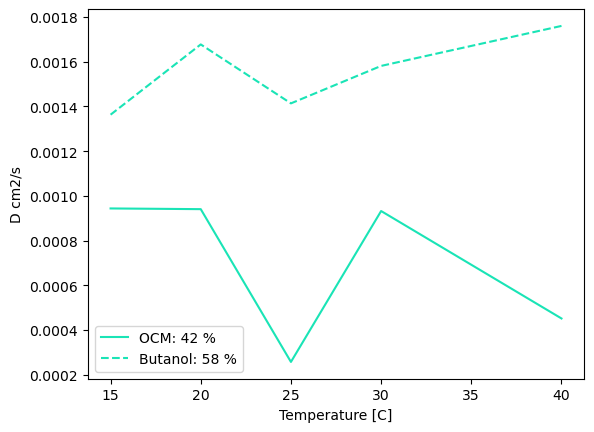

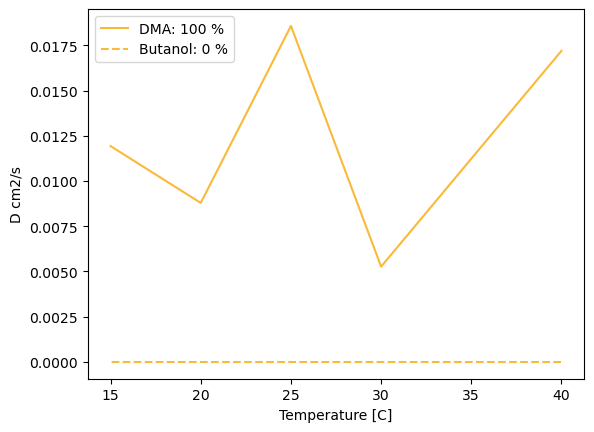

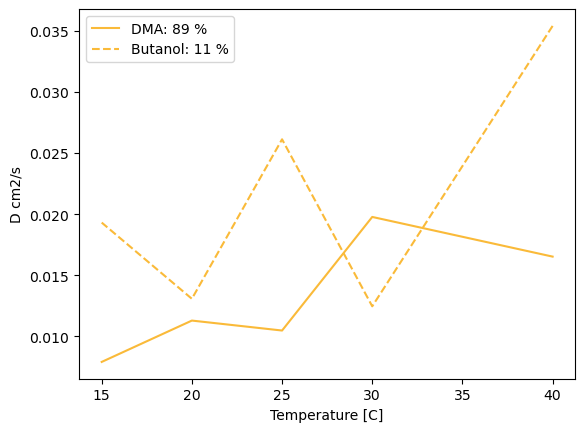

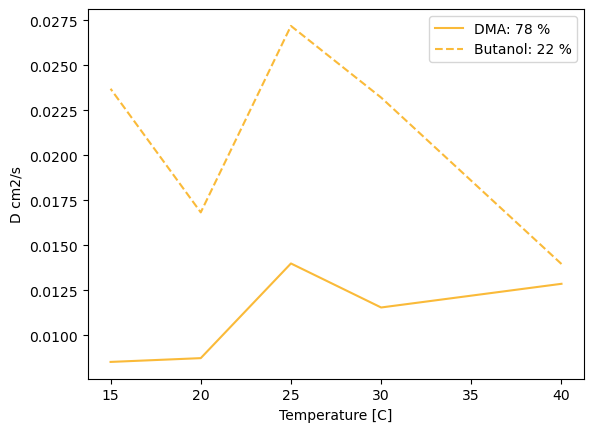

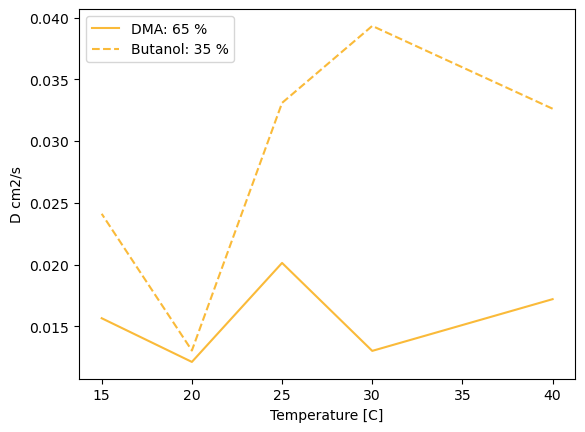

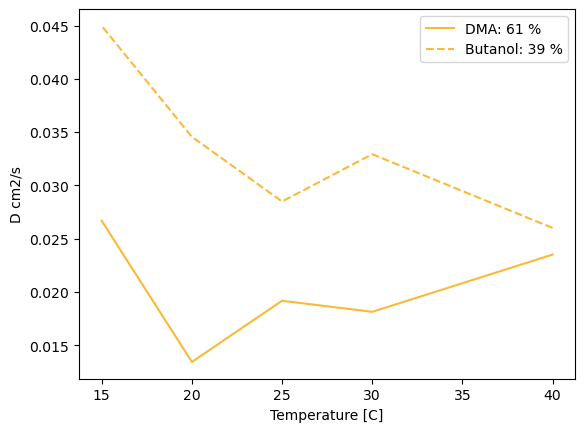

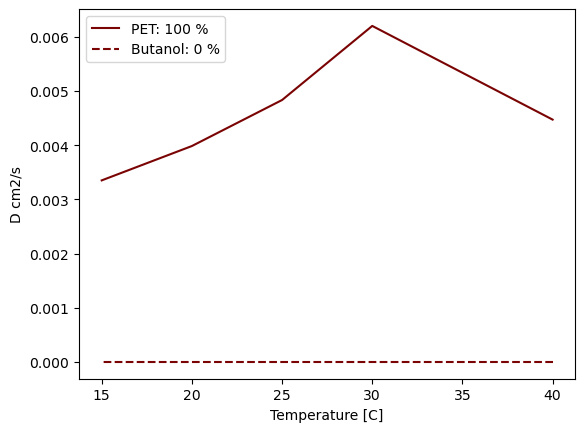

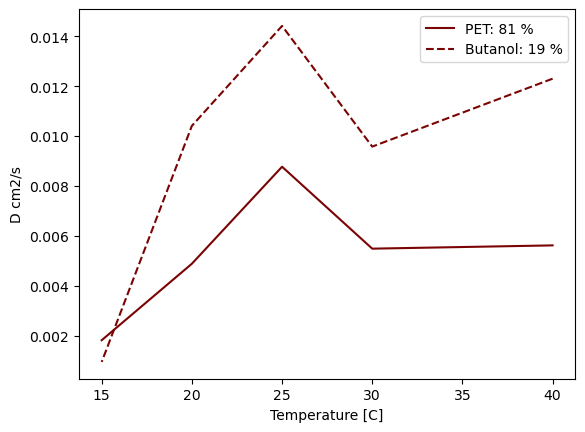

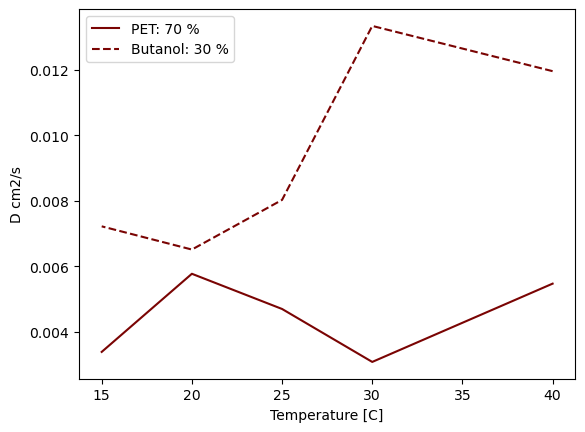

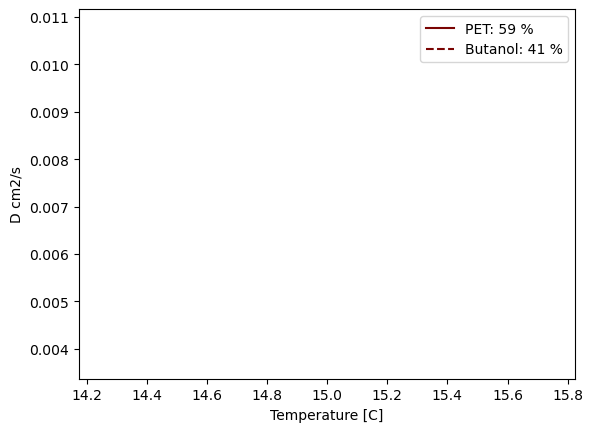

In [14]:
# D
colors_list = mcp.gen_color(
    cmap="turbo",
    n=len(DF_D['substance'].unique()),
)
i = 0
for compound in base.MolNames:
    compound = compound.value
    df_sub = DF_D[DF_D['substance'] == compound]
    if len(df_sub) == 0:
        continue

    # fig, ax = plt.subplots(num="DT")

    for [x], df in df_sub.groupby(by=['x']):
        fig, ax = plt.subplots(num="DT")
        data_x = df.sort_values(by=['T'], ascending=False)
        ax.plot(
            data_x['T'],
            data_x['D_substance'],
            label=f"{compound}: {100-x} %",
            c=colors_list[i],
        )
        ax.plot(
            data_x['T'],
            data_x['D_butanol'],
            linestyle='dashed',
            label=f"Butanol: {x} %",
            c=colors_list[i],
        )

        ax.set_xlabel("Temperature [C]")
        ax.set_ylabel("D cm2/s")
        ax.legend()
    i += 1